# **Importações Principais**

In [ ]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from matplotlib import pyplot as plt
import tensorflow
import random
from glob import glob
from imageio import mimread
from google.colab.patches import cv2_imshow
tensorflow.__version__

'2.15.0'

##Criando a extensão para acesso ao Google Drive



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##Função de carregamento de dataset/divisão das amostras de treinamento e teste

In [ ]:
def carregar_dataset(caminho):
  X_train = sorted(glob(os.path.join(caminho, "training", "images", "*.tif")))
  y_train = sorted(glob(os.path.join(caminho, "training", "1st_manual", "*.gif")))

  X_test = sorted(glob(os.path.join(caminho, "test", "images", "*.tif")))
  y_test = sorted(glob(os.path.join(caminho, "test", "1st_manual", "*.gif")))

  return (X_train, y_train), (X_test, y_test)

In [ ]:
!cp /content/gdrive/MyDrive/drive_dataset/ /content/

cp: -r not specified; omitting directory '/content/gdrive/MyDrive/drive_dataset/'


## Chamada da função para criação das pastas de treinamento/ teste

In [ ]:
path_dataset = "/content/gdrive/MyDrive/drive_dataset"
(X_train, y_train), (X_test, y_test) = carregar_dataset(path_dataset)

### Verificação do tamanho das amostras de treinamento

In [ ]:
len(X_train), len(y_train)

(760, 760)

### Verificação do tamanho das amostras de teste

In [ ]:
len(X_test), len(y_test)

(760, 760)

## Definindo a altura e largura das imagens (em pixels)

In [ ]:
img_altura = 512
img_largura = 512

# Data Augmentation

## Instalação da bibiloteca Albumentations para geração de novas imagens

In [ ]:
!pip install -U git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-l0m8_97p
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-l0m8_97p
  Resolved https://github.com/albumentations-team/albumentations to commit d40477d5643e5031278312cfe924d241b3ae3afd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 86.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 100.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 43.6 MB/s eta 0:00:00
  Created wheel for albumentations: filename=albumentations-1.4.8-py3-none-any.whl size=159056 sha256=78c925215cb8583068af781b3603faaeb015f682555a301e3d25cea3ff0f1c31
  Stored in directory: /tmp/pip-ephem-wheel-cache-ugarq_yj/wheels/51/4d/ab/5aafa8b980086fbc362946de7da4a

Importando as bibliotecas para Giro Horizontal (HorizontalFlip), Giro Vertical (VerticalFlip), Transformação Elástica (ElasticTransform), Distorção de Grade(GridDistortion), Distorção Óptica (OpticalDistortion) e Regiões de abandono/buracos (CoarseDropout)

In [ ]:
from albumentations import HorizontalFlip, VerticalFlip, ElasticTransform, GridDistortion, OpticalDistortion, CoarseDropout

## Função de garantia para diretórios

In [ ]:
def criar_diretorio(caminho):
  if not os.path.exists(caminho):
    os.makedirs(caminho)

## Criação de novos diretórios de treinamento/teste com as novas imagens geradas

In [ ]:
criar_diretorio('/content/dataset_final_aug3/train/images')
criar_diretorio('/content/dataset_final_aug3/train/mask')

criar_diretorio('dataset_final_aug3/test/images')
criar_diretorio('dataset_final_aug3/test/mask')

## Função geradora de novas imagens a partir da biblioteca Albumentations

In [ ]:
def novas_imagens(imagens, mascaras, dir_salvo, img_altura=512, img_largura=512, augmentation=True):
  for idx, (x, y) in tqdm(enumerate(zip(imagens, mascaras)), total = len(imagens)):
    nome = x.split('/')[-1].split('.')[0]
    #print(nome)

    x = cv2.imread(x)
    y = mimread(y)[0]

    if augmentation:
      aug = HorizontalFlip(p = 1.0)
      augmentation = aug(image = x, mask = y)
      x1 = augmentation['image']
      y1 = augmentation['mask']

      #aug = VerticalFlip(p = 0.0)
      #augmentation = aug(image = x, mask = y)
      #x2 = augmentation['image']
      #y2 = augmentation['mask']

      #aug = OpticalDistortion(p = 0.0, distort_limit = 2, shift_limit=0.5)
      #augmentation = aug(image = x, mask = y)
      #x3 = augmentation['image']
      #y3 = augmentation['mask']

      #aug = ElasticTransform(p = 0.0, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)
      #augmentation = aug(image = x, mask = y)
      #x4 = augmentation['image']
      #y4 = augmentation['mask']

      #aug = GridDistortion(p = 0.0)
      #augmentation = aug(image = x, mask = y)
      #x5 = augmentation['image']
      #y5 = augmentation['mask']

      X = [x, x1]#, x2, x3, x4, x5]
      y = [y, y1]#, y2, y3, y4, y5]
    else:
      X = [x]
      y = [y]

    indice = 0
    for img, mask in zip(X, y):
      img = cv2.resize(img, (img_largura, img_altura))
      mask = cv2.resize(mask, (img_largura, img_altura))

      if len(X) == 1:
        tmp_img_nome = f"{nome}.png"
        tmp_mask_nome = f"{nome}.png"
      else:
        tmp_img_nome = f"{nome}_{indice}.png"
        tmp_mask_nome = f"{nome}_{indice}.png"

      path_imagem = os.path.join(dir_salvo, "images", tmp_img_nome)
      path_mascara = os.path.join(dir_salvo, "mask", tmp_mask_nome)

      cv2.imwrite(path_imagem, img)
      cv2.imwrite(path_mascara, mask)

      indice += 1

### Inserindo imagens de treinamento no novo diretório

In [ ]:
novas_imagens(X_train, y_train, 'dataset_final_aug3/train/', augmentation=True)

100%|██████████| 760/760 [00:30<00:00, 24.94it/s]


### Inserindo imagens de teste no novo diretório

In [ ]:
novas_imagens(X_test, y_test, 'dataset_final_aug3/test/', augmentation=True)

100%|██████████| 760/760 [13:24<00:00,  1.06s/it]


### Função para deslocamento de diretórios no Google Drive

In [ ]:
import shutil
import os

def copy_directory(source_dir, destination_dir):
    # Verifica se o diretório de origem existe
    if not os.path.exists(source_dir):
        raise ValueError(f"Source directory {source_dir} does not exist")

    # Cria o diretório de destino se ele não existir
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    # Lista os itens no diretório de origem e ordena para manter a ordem original
    items = sorted(os.listdir(source_dir))

    for item in items:
        source_item = os.path.join(source_dir, item)
        destination_item = os.path.join(destination_dir, item)

        if os.path.isdir(source_item):
            # Se o item for um diretório, chama a função recursivamente
            copy_directory(source_item, destination_item)
        else:
            # Se o item for um arquivo, copia-o para o diretório de destino
            shutil.copy2(source_item, destination_item)

# Exemplo de uso:
source_directory = '/content/dataset_final_aug3/'
destination_directory = '/content/gdrive/MyDrive/dataset_final_aug2'

copy_directory(source_directory, destination_directory)


## Carregamento das imagens para treinamento do modelo

In [ ]:
dir_geradas_train = '/content/gdrive/MyDrive/dataset_final_aug2/train/'
imgs_geradas = [os.path.join(dir_geradas_train + 'images', f) for f in os.listdir(dir_geradas_train + 'images')]
masks_geradas = [os.path.join(dir_geradas_train + 'mask', f) for f in os.listdir(dir_geradas_train + 'mask')]

### Contagem de imagens geradas

In [ ]:
len(imgs_geradas)

1520

### Contagem de máscaras geradas

In [ ]:
len(masks_geradas)

1520

## Amostra as 10 primeiras imagens e suas respectivas máscaras

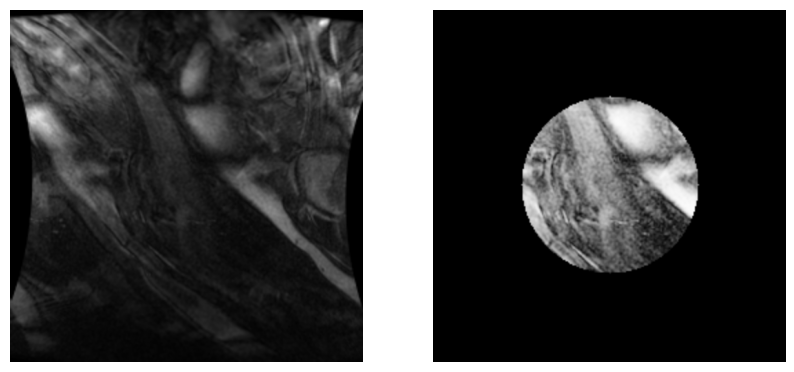

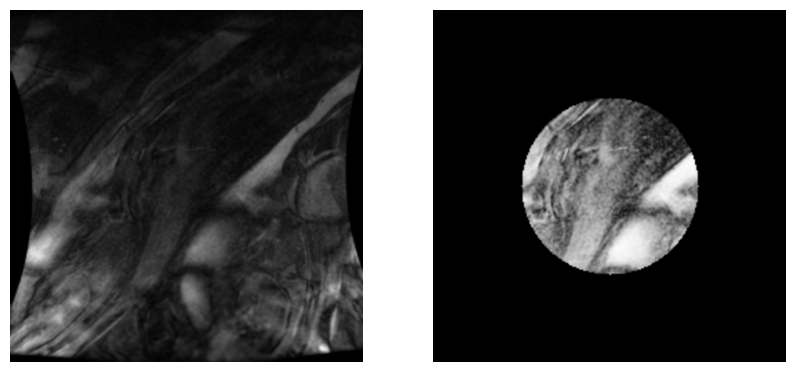

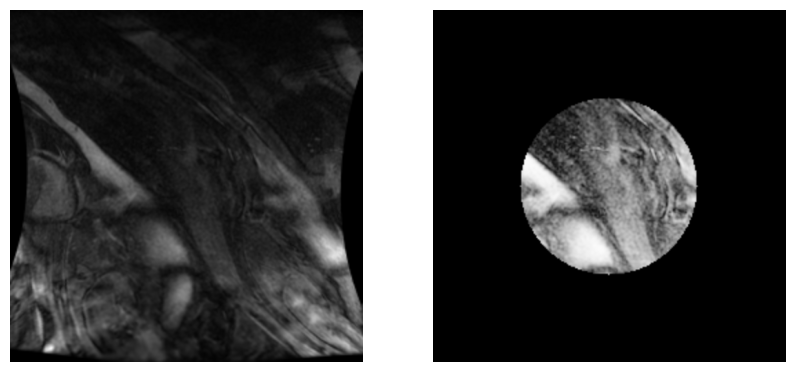

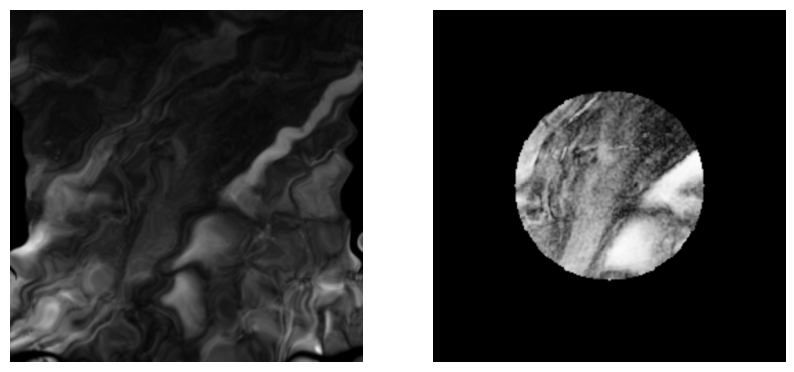

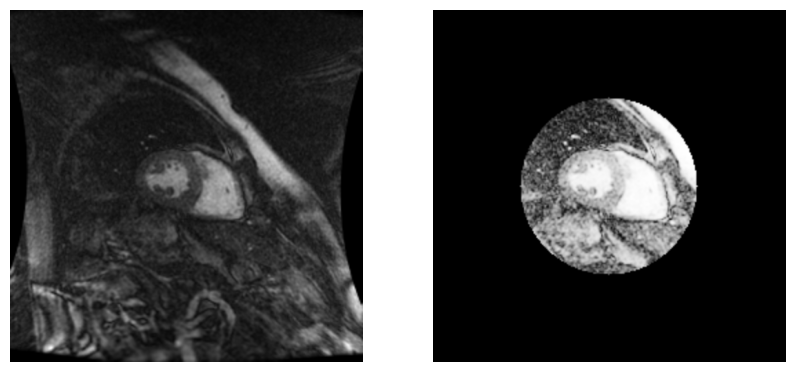

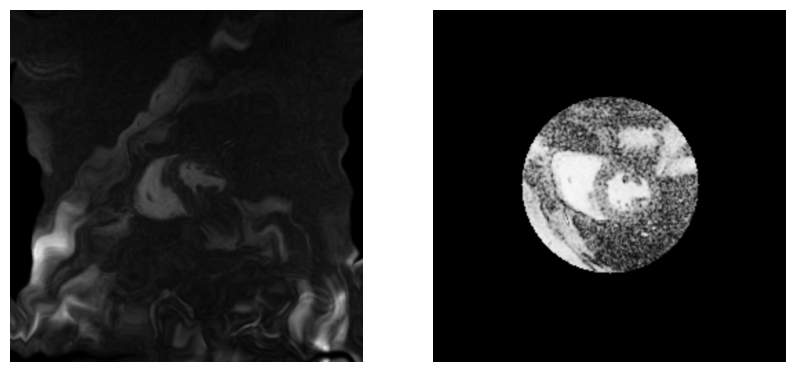

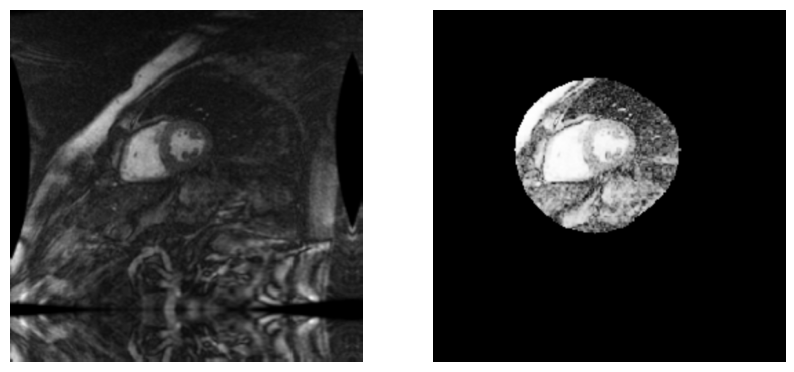

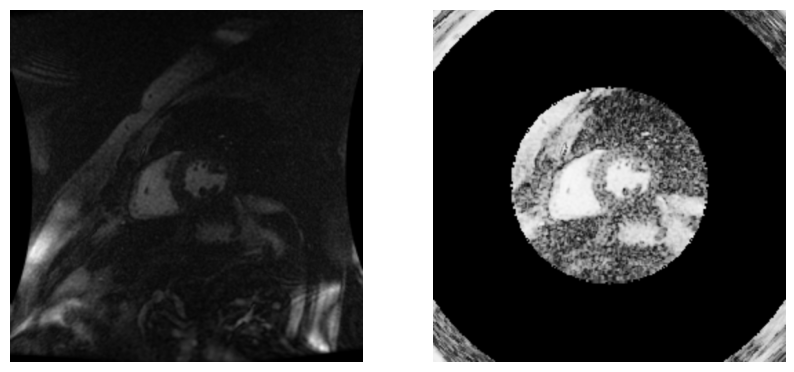

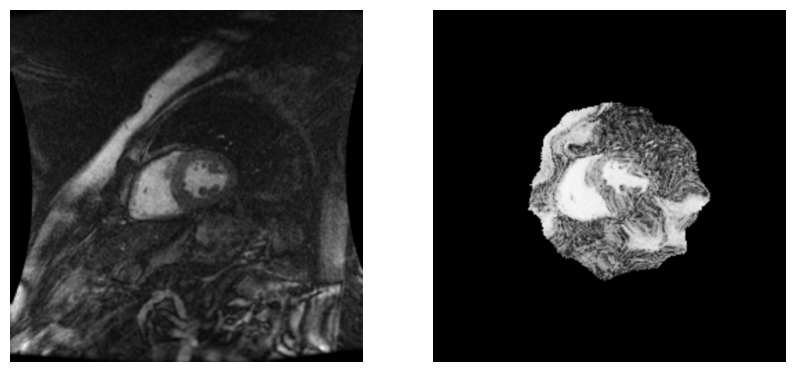

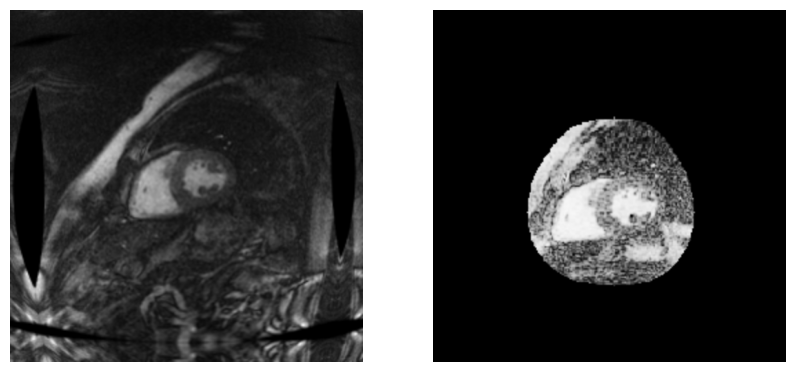

In [ ]:
for i in range(10):
  fig = plt.figure(figsize=(10,7))

  fig.add_subplot(1,2,1)
  img_teste = cv2.imread(imgs_geradas[i])
  plt.imshow(cv2.cvtColor(img_teste, cv2.COLOR_BGR2RGB))
  plt.axis('off')

  fig.add_subplot(1,2,2)
  mask_teste = cv2.imread(masks_geradas[i])
  plt.imshow(cv2.cvtColor(mask_teste, cv2.COLOR_BGR2RGB))
  plt.axis('off')

# Construção da Rede Neural

## Importações para modelo, definição dos modelos de Convolução, Encoder e Decoder e Definição da Rede U-Net

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.metrics import Recall, Precision

def bloco_conv(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def bloco_encoder(input, num_filters):
    x = bloco_conv(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p


def bloco_decoder(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = bloco_conv(x, num_filters)
    return x


def modelo_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = bloco_encoder(inputs, 64)
    s2, p2 = bloco_encoder(p1, 64*2) #128
    s3, p3 = bloco_encoder(p2, 64*4) #256
    s4, p4 = bloco_encoder(p3, 64*8) #512

    b1 = bloco_conv(p4, 64*16)  #1024

    d1 = bloco_decoder(b1, s4, 64*8) #512
    d2 = bloco_decoder(d1, s3, 64*4) #256
    d3 = bloco_decoder(d2, s2, 64*2) #128
    d4 = bloco_decoder(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNet")
    return model

## Definição das métricas de avaliação Intersection Over Union (IoU), Dice Coefficient e Dice Coefficient Loss

In [ ]:
from keras import backend as K

""" IoU """
def iou(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

""" Dice Coefficient """
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

""" Dice Coefficient Loss """
def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

## Parâmetros gerais da rede (Épocas, tamanho do batchs e velocidade de leitura)

In [ ]:
epochs = 100
batch_size = 4
lr = 1e-4

## Chamada do modelo, compilação com Otimizador Adam e sumário

In [ ]:
model = modelo_unet((img_altura, img_largura, 3))
model.compile(loss=dice_coef_loss, optimizer=Adam(lr), metrics = [dice_coef, iou, 'accuracy'])
model.summary()

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 512, 512, 64)         0         ['batch_normalization[0][0]

# Treinamento do modelo

## Função de carregamento em ordem

In [ ]:
def carregar_imagens(path):
  x = sorted(glob(os.path.join(path, 'images', '*.png')))
  y = sorted(glob(os.path.join(path, 'mask', '*.png')))
  return x, y

## Funções de conversão das imagens/máscaras para o modelo e embaralhamento

In [ ]:
def ler_img_dataset(caminho):
  caminho = caminho.decode()
  img = cv2.imread(caminho)
  img = img / 255.0
  img = img.astype(np.float32)
  return img

In [ ]:
def ler_mask_dataset(caminho):
  caminho = caminho.decode()
  img = cv2.imread(caminho, cv2.IMREAD_GRAYSCALE)
  img = img / 255.0
  img = img.astype(np.float32)
  img = np.expand_dims(img, axis = -1) # (512, 512) -> (512, 512, 1)
  return img

In [ ]:
def tf_parse(x, y):
  def _parse(x, y):
    x = ler_img_dataset(x)
    y = ler_mask_dataset(y)
    return x, y

  x, y = tensorflow.numpy_function(_parse, [x, y], [tensorflow.float32, tensorflow.float32])
  x.set_shape([img_altura, img_largura, 3])
  y.set_shape([img_altura, img_largura, 1])
  return x, y

In [ ]:
def tf_dataset(X, y, batch_size=2):
  dataset = tensorflow.data.Dataset.from_tensor_slices((X, y))
  dataset = dataset.map(tf_parse)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(4)
  return dataset

In [ ]:
from sklearn.utils import shuffle
def embaralha(x, y): #, seed=42
  x, y = shuffle(x, y) #, random_state=seed
  return x, y

## Definição de diretório alvo, verificando caminhos

In [ ]:
dir_dataset = '/content/gdrive/MyDrive/dataset_final/'
path_train = os.path.join(dir_dataset, 'train')
path_val = os.path.join(dir_dataset, 'test')
print(path_train, path_val)

/content/gdrive/MyDrive/dataset_final/train /content/gdrive/MyDrive/dataset_final/test


## Chamada das funções

In [ ]:
X_train, y_train = carregar_imagens(path_train)
X_train, y_train = embaralha(X_train, y_train)
X_val, y_val = carregar_imagens(path_val)

### Confêrencia

In [ ]:
len(X_train), len(y_train)

(1520, 1520)

In [ ]:
len(X_val), len(y_val)

(1520, 1520)

### Adequação de Batch Size

In [ ]:
dataset_train = tf_dataset(X_train, y_train, batch_size=batch_size)
dataset_val = tf_dataset(X_val, y_val, batch_size=batch_size)

## Criação de diretório para armazenar os checkpoints do modelo

In [ ]:
path_modelo = 'modelos_teste761'
criar_diretorio(path_modelo)

## Criação de callbacks, Definição de patience para 5 épocas e salvando apenas o melhor resultado

In [ ]:
callbacks = [ModelCheckpoint(path_modelo + '/modelo_drive_{epoch:02d}.h5', verbose=1, save_best_only=True),
             EarlyStopping(monitor='val_loss', patience=5)]

## Execução do Treinamento

In [ ]:
history = model.fit(dataset_train, epochs=epochs, validation_data=dataset_val, callbacks=callbacks)

Epoch 1/100
380/380 [==============================] - ETA: 0s - loss: 0.5165 - dice_coef: 0.4835 - iou: 0.3246 - accuracy: 0.6905
Epoch 1: val_loss improved from inf to 0.64967, saving model to modelos_teste761/modelo_drive_01.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


380/380 [==============================] - 2749s 7s/step - loss: 0.5165 - dice_coef: 0.4835 - iou: 0.3246 - accuracy: 0.6905 - val_loss: 0.6497 - val_dice_coef: 0.3503 - val_iou: 0.2128 - val_accuracy: 0.5315
Epoch 2/100
380/380 [==============================] - ETA: 0s - loss: 0.3912 - dice_coef: 0.6088 - iou: 0.4408 - accuracy: 0.7711
Epoch 2: val_loss improved from 0.64967 to 0.38204, saving model to modelos_teste761/modelo_drive_02.h5
380/380 [==============================] - 526s 1s/step - loss: 0.3912 - dice_coef: 0.6088 - iou: 0.4408 - accuracy: 0.7711 - val_loss: 0.3820 - val_dice_coef: 0.6180 - val_iou: 0.4502 - val_accuracy: 0.7644
Epoch 3/100
380/380 [==============================] - ETA: 0s - loss: 0.3248 - dice_coef: 0.6752 - iou: 0.5126 - accuracy: 0.7879
Epoch 3: val_loss improved from 0.38204 to 0.31643, saving model to modelos_teste761/modelo_drive_03.h5
380/380 [==============================] - 527s 1s/step - loss: 0.3248 - dice_coef: 0.6752 - iou: 0.5126 - accura

## Função para transferir os checkpoints do modelo para o Google Drive

In [ ]:
import shutil
import os

def copy_directory(source_dir, destination_dir):
    # Verifica se o diretório de origem existe
    if not os.path.exists(source_dir):
        raise ValueError(f"Source directory {source_dir} does not exist")

    # Cria o diretório de destino se ele não existir
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    # Lista os itens no diretório de origem e ordena para manter a ordem original
    items = sorted(os.listdir(source_dir))

    for item in items:
        source_item = os.path.join(source_dir, item)
        destination_item = os.path.join(destination_dir, item)

        if os.path.isdir(source_item):
            # Se o item for um diretório, chama a função recursivamente
            copy_directory(source_item, destination_item)
        else:
            # Se o item for um arquivo, copia-o para o diretório de destino
            shutil.copy2(source_item, destination_item)

# Exemplo de uso:
source_directory = '/content/modelos_teste761/'
destination_directory = '/content/gdrive/MyDrive/modelos_teste761/'

copy_directory(source_directory, destination_directory)

# Salvar e carregar o modelo (Google Drive)

## Copia modelo da pasta raiz para uma pasta no Drive

In [ ]:
!cp /content/modelos/modelo_drive_40.h5 /content/gdrive/MyDrive/modelos/modelo_drive_40.h5

## Copia modelo de uma pasta do Drive para pasta raiz

In [ ]:
!cp /content/gdrive/MyDrive/Cursos\ -\ recursos/Segmentação\ Imagens\ Python\ AZ/modelos/modelo_drive_40.h5 modelo_drive_40.h5

# Carregamento de Modelos e Resultados

## Importações para Carregamento de Checkpoints e métricas

In [ ]:
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.models import load_model

In [ ]:
with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_coef_loss': dice_coef_loss}):
  modelo_teste = load_model('/content/gdrive/MyDrive/modelos/modelo_drive_17.h5')#'/content/gdrive/MyDrive/modelos_aug2/modelo_drive_25.h5')

In [ ]:
modelo_teste.load_weights('/content/gdrive/MyDrive/modelos/modelo_drive_17.h5')

## Testes

### Carregando imagens originais para comparação

In [ ]:
def ler_img(caminho):
  img = cv2.imread(caminho, cv2.IMREAD_COLOR)
  img_original = img.copy()
  img = img / 255.0
  img = img.astype(np.float32)
  return img, img_original

In [ ]:
def ler_mascara(caminho):
    img = cv2.imread(caminho, cv2.IMREAD_GRAYSCALE)
    img_original = img
    img = img/255.0
    img = img.astype(np.int32)
    return img, img_original

### Definindo o modelo de predição de segmentação

In [ ]:
def segmenta_img(img, modelo_teste):
  predicao = modelo_teste.predict(np.expand_dims(img, axis=0))[0]
  predicao = predicao > 0.5
  predicao = predicao.astype(np.int32)
  predicao = np.squeeze(predicao, axis=-1)
  return predicao

In [ ]:
dataset_path = os.path.join('/content/gdrive/MyDrive/dataset_final', 'test')
test_imgs, test_masks = carregar_imagens(dataset_path)

In [ ]:
len(test_imgs), len(test_masks)

(760, 760)

In [ ]:
test_imgs

['/content/gdrive/MyDrive/dataset_final/test/images/img (1).png',
 '/content/gdrive/MyDrive/dataset_final/test/images/img (10).png',
 '/content/gdrive/MyDrive/dataset_final/test/images/img (100).png',
 '/content/gdrive/MyDrive/dataset_final/test/images/img (101).png',
 '/content/gdrive/MyDrive/dataset_final/test/images/img (102).png',
 '/content/gdrive/MyDrive/dataset_final/test/images/img (103).png',
 '/content/gdrive/MyDrive/dataset_final/test/images/img (104).png',
 '/content/gdrive/MyDrive/dataset_final/test/images/img (105).png',
 '/content/gdrive/MyDrive/dataset_final/test/images/img (106).png',
 '/content/gdrive/MyDrive/dataset_final/test/images/img (107).png',
 '/content/gdrive/MyDrive/dataset_final/test/images/img (108).png',
 '/content/gdrive/MyDrive/dataset_final/test/images/img (109).png',
 '/content/gdrive/MyDrive/dataset_final/test/images/img (11).png',
 '/content/gdrive/MyDrive/dataset_final/test/images/img (110).png',
 '/content/gdrive/MyDrive/dataset_final/test/images/

### Pega randomicamente 5 imagens, e mostra a imagem original, sua máscara e a predição da rede U-Net

1/1 [==============================] - 0s 21ms/step


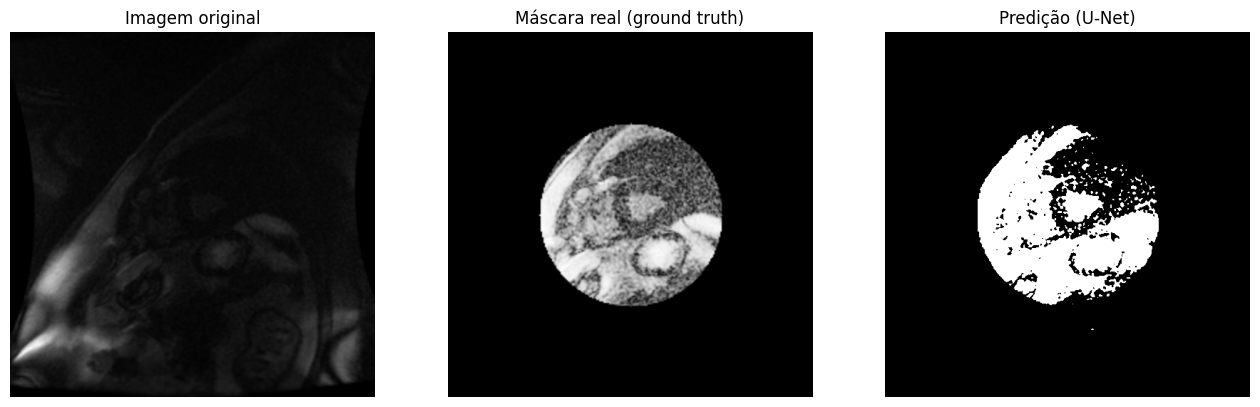

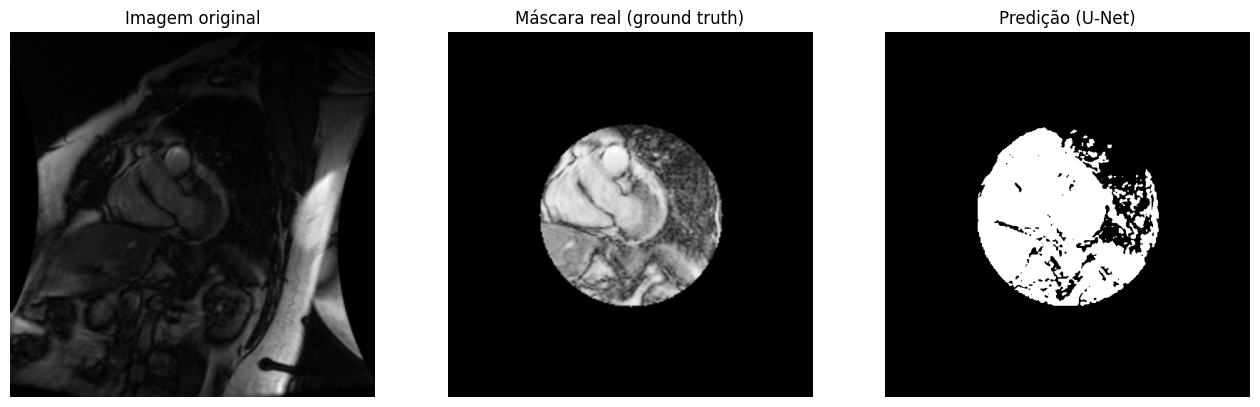

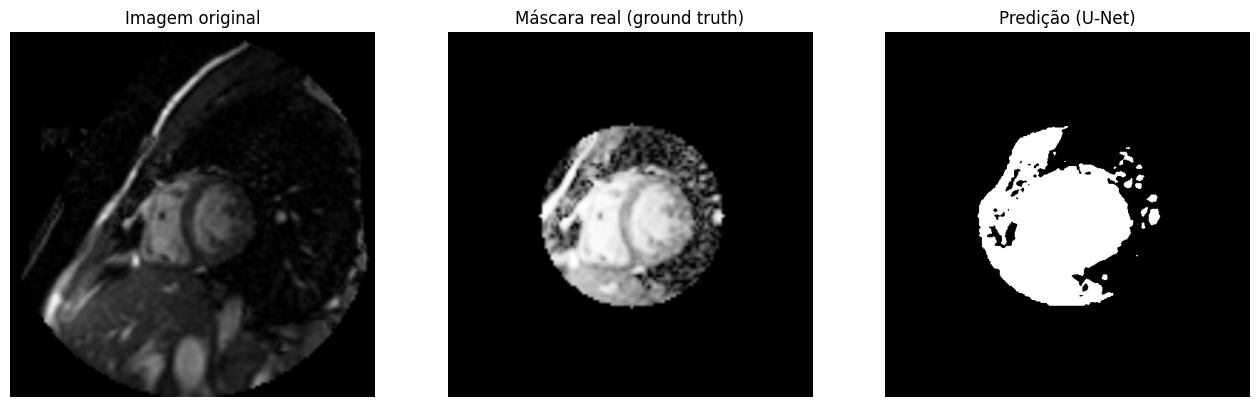

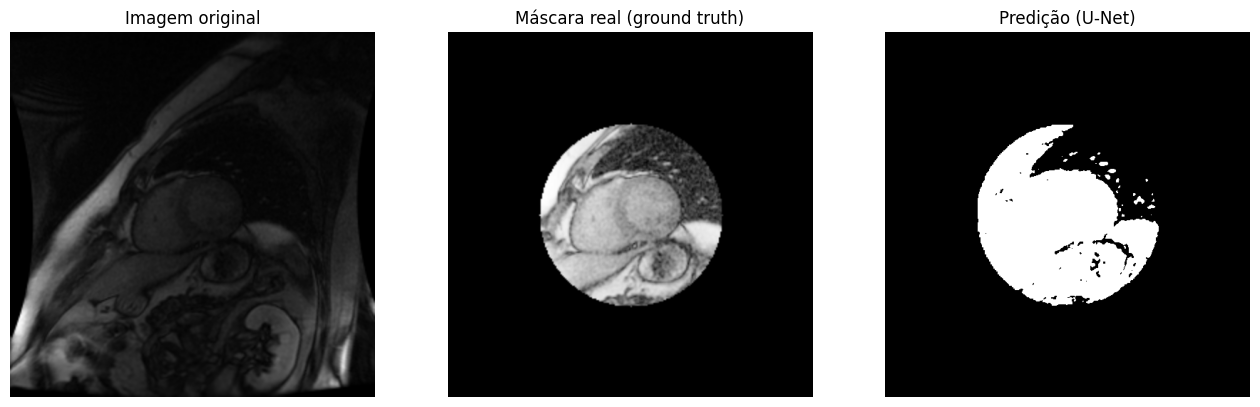

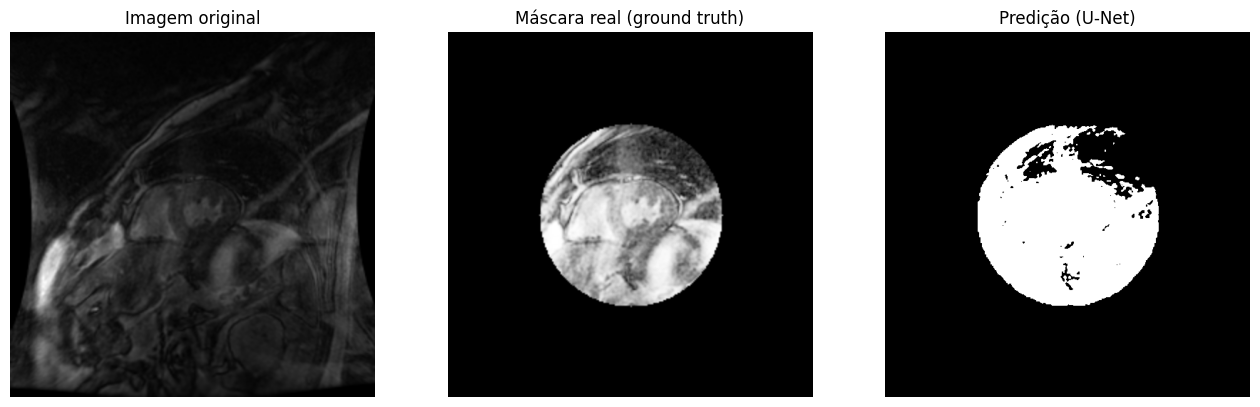

In [ ]:
lista_teste = np.random.choice(len(test_imgs), 5)
#print(lista_teste)
for id_img in lista_teste:
  img, img_original = ler_img(test_imgs[id_img])
  mask, mask_original = ler_mascara(test_masks[id_img])
  predicao = segmenta_img(img, modelo_teste)

  fig = plt.figure(figsize=(16, 8))
  fig.add_subplot(1,3,1)
  plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
  plt.axis("off")
  plt.title("Imagem original")

  plt.subplot(1,3,2)
  plt.imshow(mask_original, cmap="gray")
  plt.axis("off")
  plt.title("Máscara real (ground truth)")

  plt.subplot(1,3,3)
  plt.imshow(predicao, cmap="gray")
  plt.axis("off")
  plt.title("Predição (U-Net)")

### Aplica a predição na imagem original, para mostrar o quanto o algoritmo segmenta da região da imagem original

1/1 [==============================] - 5s 5s/step
(512, 512, 3)


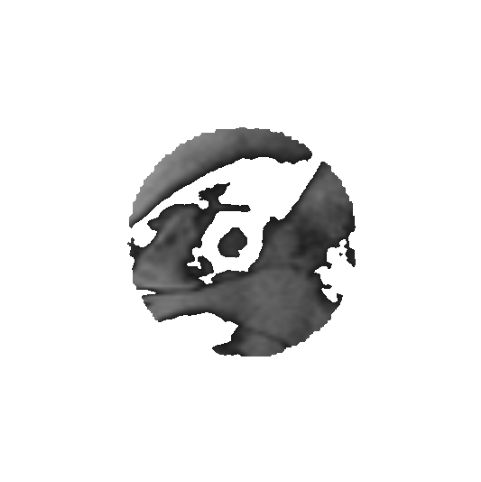

In [ ]:
id_img = 0
img, img_original = ler_img(test_imgs[id_img])
mask, mask_original = ler_mascara(test_masks[id_img])
predicao = segmenta_img(img, modelo_teste)
print(img.shape)

altura, largura = img.shape[:2]
fundo_branco = 255 * np.ones((altura, largura, 3), dtype='uint8')
img_final = img_original.copy()
img_final[predicao == 0] = fundo_branco[predicao == 0]

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(img_final, cv2.COLOR_BGR2RGB))
plt.axis('off');

# Avaliação

## Importação do Accuracy Score e IoU

In [ ]:
from sklearn.metrics import accuracy_score
from tensorflow.keras.metrics import MeanIoU

## Leitura das imagens e predição

In [ ]:
id_img = 0
img, img_original = ler_img(test_imgs[id_img])
mask, mask_original = ler_mascara(test_masks[id_img])
predicao = segmenta_img(img, modelo_teste)

1/1 [==============================] - 0s 20ms/step


### Formato das imagens

In [ ]:
mask.shape, predicao.shape

((512, 512), (512, 512))

## Achatamento das imagens e predição para métricas

In [ ]:
pred_ = predicao.flatten()
mask_ = mask.flatten()
pred_.shape, mask_.shape

((262144,), (262144,))

## Aplicação do Iou

In [ ]:
# IoU
iou_resultado = MeanIoU(num_classes = 2)
iou_resultado.update_state(mask, predicao)
valor_iou = iou_resultado.result().numpy()

In [ ]:
mask_, np.unique(mask_, return_counts=True)

(array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 (array([0], dtype=int32), array([262144])))

In [ ]:
pred_, np.unique(pred_, return_counts=True)

(array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 (array([0, 1], dtype=int32), array([225611,  36533])))

## Aplicação do Accuracy

In [ ]:
valor_acc = accuracy_score(mask_, pred_)

## Plot da região de predição, com ambas as métricas

IoU:  0.43096924
Accuracy:  0.8619384765625


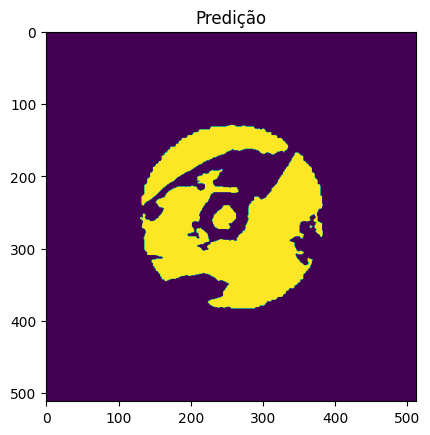

In [ ]:
plt.imshow(predicao)
plt.title('Predição')
print('IoU: ', valor_iou)
print('Accuracy: ', valor_acc)

## Teste com todas as imagens e predições em ambas as métricas em lista e cálculo das médias de IoU e Accuracy

In [ ]:
lista_scores = []
for x, y in tqdm(zip(test_imgs, test_masks), total=len(test_imgs)):
    nome = x.split("/")[-1].split(".")[0]

    img, img_original = ler_img(x)
    mask, mask_original = ler_mascara(y)
    predicao = segmenta_img(img, modelo_teste)

    mask_ = mask.flatten()
    pred_ = predicao.flatten()

    IoU_resultado = MeanIoU(num_classes=2)
    IoU_resultado.update_state(mask, predicao)
    valor_iou = IoU_resultado.result().numpy()

    valor_acc = accuracy_score(mask_, pred_)

    lista_scores.append([nome, valor_iou, valor_acc])

medias_score = [s[1:] for s in lista_scores]
medias_score = np.mean(medias_score, axis=0)
print(f"\nMédia do IoU: {medias_score[0]:0.5f}")
print(f"Média do Accuracy: {medias_score[1]:0.5f}")

  0%|          | 0/1520 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 1/1520 [00:00<05:27,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 2/1520 [00:00<05:08,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 3/1520 [00:00<04:53,  5.17it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 4/1520 [00:00<04:44,  5.33it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 5/1520 [00:00<04:42,  5.35it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 6/1520 [00:01<04:41,  5.37it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 7/1520 [00:01<04:38,  5.42it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 8/1520 [00:01<04:39,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 9/1520 [00:01<04:37,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 10/1520 [00:01<04:35,  5.48it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 11/1520 [00:02<04:35,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 12/1520 [00:02<04:32,  5.53it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 13/1520 [00:02<04:33,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 14/1520 [00:02<04:35,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 15/1520 [00:02<04:34,  5.49it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 16/1520 [00:02<04:38,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 17/1520 [00:03<04:34,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 18/1520 [00:03<04:41,  5.33it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 19/1520 [00:03<04:37,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 20/1520 [00:03<04:34,  5.47it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 21/1520 [00:03<04:34,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 22/1520 [00:04<04:33,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 23/1520 [00:04<04:32,  5.49it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 24/1520 [00:04<04:39,  5.35it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 25/1520 [00:04<04:40,  5.34it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 26/1520 [00:04<04:37,  5.39it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 27/1520 [00:04<04:35,  5.42it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 28/1520 [00:05<04:34,  5.43it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 29/1520 [00:05<04:35,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 30/1520 [00:05<04:34,  5.43it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 31/1520 [00:05<04:33,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 32/1520 [00:05<04:35,  5.40it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 33/1520 [00:06<04:30,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 34/1520 [00:06<04:28,  5.53it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 35/1520 [00:06<04:28,  5.53it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 36/1520 [00:06<04:27,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 37/1520 [00:06<04:26,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▎         | 38/1520 [00:07<04:34,  5.41it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 39/1520 [00:07<04:36,  5.37it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 40/1520 [00:07<04:38,  5.32it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 41/1520 [00:07<04:37,  5.32it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 42/1520 [00:07<04:34,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 43/1520 [00:07<04:32,  5.42it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 44/1520 [00:08<04:29,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 45/1520 [00:08<04:25,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 46/1520 [00:08<04:23,  5.59it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 47/1520 [00:08<04:27,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 48/1520 [00:08<04:27,  5.50it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 49/1520 [00:09<04:26,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 50/1520 [00:09<04:24,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 51/1520 [00:09<04:22,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 52/1520 [00:09<04:21,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 53/1520 [00:09<04:21,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 54/1520 [00:09<04:20,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 55/1520 [00:10<04:20,  5.62it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 56/1520 [00:10<04:24,  5.54it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 57/1520 [00:10<04:27,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 58/1520 [00:10<04:27,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 59/1520 [00:10<04:33,  5.33it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 60/1520 [00:11<04:33,  5.34it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 61/1520 [00:11<04:31,  5.36it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 62/1520 [00:11<04:30,  5.39it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 63/1520 [00:11<04:29,  5.40it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 64/1520 [00:11<04:31,  5.36it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 65/1520 [00:11<04:29,  5.40it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 66/1520 [00:12<04:27,  5.43it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 67/1520 [00:12<04:26,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 68/1520 [00:12<04:24,  5.49it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 69/1520 [00:12<04:21,  5.54it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 70/1520 [00:12<04:21,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 71/1520 [00:13<04:23,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 72/1520 [00:13<04:25,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 73/1520 [00:13<04:25,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 74/1520 [00:13<04:25,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 75/1520 [00:13<04:24,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 76/1520 [00:13<04:22,  5.50it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 77/1520 [00:14<04:21,  5.53it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 78/1520 [00:14<04:20,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 79/1520 [00:14<04:25,  5.42it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 80/1520 [00:14<04:31,  5.30it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 81/1520 [00:14<04:30,  5.32it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 82/1520 [00:15<04:29,  5.34it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 83/1520 [00:15<04:29,  5.34it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 84/1520 [00:15<04:29,  5.33it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 85/1520 [00:15<04:27,  5.36it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 86/1520 [00:15<04:26,  5.39it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 87/1520 [00:16<04:28,  5.34it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 88/1520 [00:16<04:32,  5.26it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 89/1520 [00:16<04:30,  5.29it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 90/1520 [00:16<04:28,  5.33it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 91/1520 [00:16<04:26,  5.36it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 92/1520 [00:16<04:23,  5.41it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 93/1520 [00:17<04:21,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 94/1520 [00:17<04:21,  5.44it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 95/1520 [00:17<04:24,  5.39it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 96/1520 [00:17<04:26,  5.33it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 97/1520 [00:17<04:26,  5.33it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 98/1520 [00:18<04:24,  5.37it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 99/1520 [00:18<04:23,  5.39it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 100/1520 [00:18<04:28,  5.29it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 101/1520 [00:18<04:24,  5.37it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 102/1520 [00:18<04:20,  5.43it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 103/1520 [00:18<04:17,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 104/1520 [00:19<04:18,  5.49it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 105/1520 [00:19<04:16,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 106/1520 [00:19<04:17,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 107/1520 [00:19<04:17,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 108/1520 [00:19<04:18,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 109/1520 [00:20<04:18,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 110/1520 [00:20<04:17,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 111/1520 [00:20<04:17,  5.48it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 112/1520 [00:20<04:18,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 113/1520 [00:20<04:14,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 114/1520 [00:20<04:12,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 115/1520 [00:21<04:12,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 116/1520 [00:21<04:14,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 117/1520 [00:21<04:15,  5.48it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 118/1520 [00:21<04:15,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 119/1520 [00:21<04:15,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 120/1520 [00:22<04:18,  5.41it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 121/1520 [00:22<04:23,  5.30it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 122/1520 [00:22<04:22,  5.33it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 123/1520 [00:22<04:18,  5.40it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 124/1520 [00:22<04:16,  5.44it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 125/1520 [00:23<04:14,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 126/1520 [00:23<04:13,  5.49it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 127/1520 [00:23<04:12,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 128/1520 [00:23<04:15,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 129/1520 [00:23<04:15,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 130/1520 [00:23<04:16,  5.42it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 131/1520 [00:24<04:15,  5.43it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 132/1520 [00:24<04:15,  5.43it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 133/1520 [00:24<04:15,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 134/1520 [00:24<04:13,  5.48it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 135/1520 [00:24<04:10,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 136/1520 [00:25<04:11,  5.50it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 137/1520 [00:25<04:09,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 138/1520 [00:25<04:10,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 139/1520 [00:25<04:12,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 140/1520 [00:25<04:12,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 141/1520 [00:25<04:18,  5.34it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 142/1520 [00:26<04:16,  5.37it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 143/1520 [00:26<04:17,  5.36it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 144/1520 [00:26<04:20,  5.28it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 145/1520 [00:26<04:16,  5.36it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 146/1520 [00:26<04:14,  5.40it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 147/1520 [00:27<04:12,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 148/1520 [00:27<04:10,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 149/1520 [00:27<04:09,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 150/1520 [00:27<04:11,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 151/1520 [00:27<04:10,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 152/1520 [00:27<04:15,  5.36it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 153/1520 [00:28<04:15,  5.35it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 154/1520 [00:28<04:16,  5.33it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 155/1520 [00:28<04:17,  5.31it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 156/1520 [00:28<04:18,  5.29it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 157/1520 [00:28<04:17,  5.30it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 158/1520 [00:29<04:15,  5.33it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 159/1520 [00:29<04:13,  5.37it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 160/1520 [00:29<04:13,  5.37it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 161/1520 [00:29<04:17,  5.29it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 162/1520 [00:29<04:14,  5.35it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 163/1520 [00:30<04:11,  5.39it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 164/1520 [00:30<04:09,  5.43it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 165/1520 [00:30<04:09,  5.43it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 166/1520 [00:30<04:07,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 167/1520 [00:30<04:07,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 168/1520 [00:30<04:10,  5.39it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 169/1520 [00:31<04:11,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 170/1520 [00:31<04:09,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 171/1520 [00:31<04:09,  5.41it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 172/1520 [00:31<04:05,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 173/1520 [00:31<04:03,  5.53it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 174/1520 [00:32<04:01,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 175/1520 [00:32<04:00,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 176/1520 [00:32<04:01,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 177/1520 [00:32<03:59,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 178/1520 [00:32<03:58,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 179/1520 [00:32<03:56,  5.67it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 180/1520 [00:33<03:56,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 181/1520 [00:33<03:56,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 182/1520 [00:33<04:01,  5.54it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 183/1520 [00:33<03:59,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 184/1520 [00:33<04:00,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 185/1520 [00:33<03:58,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 186/1520 [00:34<03:57,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 187/1520 [00:34<03:57,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 188/1520 [00:34<03:57,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 189/1520 [00:34<03:55,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▎        | 190/1520 [00:34<03:55,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 191/1520 [00:35<03:55,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 192/1520 [00:35<03:57,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 193/1520 [00:35<03:57,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 194/1520 [00:35<03:56,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 195/1520 [00:35<03:54,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 196/1520 [00:35<03:54,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 197/1520 [00:36<03:53,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 198/1520 [00:36<03:52,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 199/1520 [00:36<03:52,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 200/1520 [00:36<03:54,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 201/1520 [00:36<03:52,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 202/1520 [00:37<03:51,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 203/1520 [00:37<03:57,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 204/1520 [00:37<03:56,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 205/1520 [00:37<03:54,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 206/1520 [00:37<03:54,  5.61it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 207/1520 [00:37<03:53,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 208/1520 [00:38<03:56,  5.54it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 209/1520 [00:38<05:42,  3.83it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 210/1520 [00:38<05:10,  4.22it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 211/1520 [00:38<04:47,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 212/1520 [00:39<04:37,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 213/1520 [00:39<04:28,  4.87it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 214/1520 [00:39<04:20,  5.01it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 215/1520 [00:39<04:14,  5.13it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 216/1520 [00:39<04:14,  5.13it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 217/1520 [00:40<04:11,  5.19it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 218/1520 [00:40<04:09,  5.22it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 219/1520 [00:40<04:09,  5.22it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 220/1520 [00:40<04:07,  5.26it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 221/1520 [00:40<04:05,  5.29it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 222/1520 [00:40<04:04,  5.31it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 223/1520 [00:41<04:06,  5.27it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 224/1520 [00:41<04:05,  5.29it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 225/1520 [00:41<04:00,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 226/1520 [00:41<03:59,  5.40it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 227/1520 [00:41<03:59,  5.39it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 228/1520 [00:42<03:59,  5.39it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 229/1520 [00:42<03:59,  5.39it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 230/1520 [00:42<04:01,  5.34it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 231/1520 [00:42<03:59,  5.37it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 232/1520 [00:42<04:01,  5.34it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 233/1520 [00:43<03:58,  5.39it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 234/1520 [00:43<03:55,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 235/1520 [00:43<03:52,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 236/1520 [00:43<03:51,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 237/1520 [00:43<03:50,  5.57it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 238/1520 [00:43<03:50,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 239/1520 [00:44<03:48,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 240/1520 [00:44<03:50,  5.56it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 241/1520 [00:44<03:50,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 242/1520 [00:44<03:49,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 243/1520 [00:44<03:48,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 244/1520 [00:44<03:51,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 245/1520 [00:45<03:50,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 246/1520 [00:45<03:49,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 247/1520 [00:45<03:47,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 248/1520 [00:45<03:47,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 249/1520 [00:45<03:46,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 250/1520 [00:46<03:46,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 251/1520 [00:46<03:46,  5.61it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 252/1520 [00:46<03:46,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 253/1520 [00:46<03:44,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 254/1520 [00:46<03:43,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 255/1520 [00:46<03:44,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 256/1520 [00:47<03:45,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 257/1520 [00:47<03:44,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 258/1520 [00:47<03:44,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 259/1520 [00:47<03:43,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 260/1520 [00:47<03:43,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 261/1520 [00:48<03:42,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 262/1520 [00:48<03:41,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 263/1520 [00:48<03:42,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 264/1520 [00:48<03:50,  5.44it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 265/1520 [00:48<03:49,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 266/1520 [00:48<03:47,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 267/1520 [00:49<03:46,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 268/1520 [00:49<03:45,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 269/1520 [00:49<03:49,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 270/1520 [00:49<03:47,  5.51it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 271/1520 [00:49<03:43,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 272/1520 [00:50<03:44,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 273/1520 [00:50<03:43,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 274/1520 [00:50<03:42,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 275/1520 [00:50<03:41,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 276/1520 [00:50<03:39,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 277/1520 [00:50<03:39,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 278/1520 [00:51<03:37,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 279/1520 [00:51<03:38,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 280/1520 [00:51<03:41,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 281/1520 [00:51<03:42,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 282/1520 [00:51<03:43,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 283/1520 [00:51<03:42,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 284/1520 [00:52<03:42,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 285/1520 [00:52<03:49,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 286/1520 [00:52<03:48,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 287/1520 [00:52<03:45,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 288/1520 [00:52<03:46,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 289/1520 [00:53<03:44,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 290/1520 [00:53<03:43,  5.50it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 291/1520 [00:53<03:42,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 292/1520 [00:53<03:42,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 293/1520 [00:53<03:41,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 294/1520 [00:53<03:40,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 295/1520 [00:54<03:40,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 296/1520 [00:54<03:42,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 297/1520 [00:54<03:41,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 298/1520 [00:54<03:38,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 299/1520 [00:54<03:38,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 300/1520 [00:55<03:36,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 301/1520 [00:55<03:35,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 302/1520 [00:55<03:35,  5.64it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 303/1520 [00:55<03:37,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 304/1520 [00:55<03:38,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 305/1520 [00:55<03:43,  5.43it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 306/1520 [00:56<03:40,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 307/1520 [00:56<03:38,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 308/1520 [00:56<03:36,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 309/1520 [00:56<03:34,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 310/1520 [00:56<03:33,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 311/1520 [00:57<03:33,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 312/1520 [00:57<03:35,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 313/1520 [00:57<03:36,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 314/1520 [00:57<03:35,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 315/1520 [00:57<03:33,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 316/1520 [00:57<03:33,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 317/1520 [00:58<03:31,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 318/1520 [00:58<03:30,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 319/1520 [00:58<03:31,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 320/1520 [00:58<03:33,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 321/1520 [00:58<03:32,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 322/1520 [00:58<03:32,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 323/1520 [00:59<03:31,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 324/1520 [00:59<03:30,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 325/1520 [00:59<03:36,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 326/1520 [00:59<03:34,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 327/1520 [00:59<03:32,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 328/1520 [01:00<03:33,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 329/1520 [01:00<03:31,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 330/1520 [01:00<03:31,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 331/1520 [01:00<03:31,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 332/1520 [01:00<03:30,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 333/1520 [01:00<03:28,  5.68it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 334/1520 [01:01<03:29,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 335/1520 [01:01<03:30,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 336/1520 [01:01<03:32,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 337/1520 [01:01<03:30,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 338/1520 [01:01<03:30,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 339/1520 [01:01<03:30,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 340/1520 [01:02<03:29,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 341/1520 [01:02<03:29,  5.62it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▎       | 342/1520 [01:02<03:29,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 343/1520 [01:02<03:27,  5.67it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 344/1520 [01:02<03:29,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 345/1520 [01:03<03:29,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 346/1520 [01:03<03:31,  5.55it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 347/1520 [01:03<03:31,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 348/1520 [01:03<03:29,  5.59it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 349/1520 [01:03<03:31,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 350/1520 [01:03<03:28,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 351/1520 [01:04<03:30,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 352/1520 [01:04<03:33,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 353/1520 [01:04<03:33,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 354/1520 [01:04<03:32,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 355/1520 [01:04<03:32,  5.49it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 356/1520 [01:05<03:31,  5.49it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 357/1520 [01:05<03:32,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 358/1520 [01:05<03:31,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 359/1520 [01:05<03:29,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 360/1520 [01:05<03:31,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 361/1520 [01:05<03:30,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 362/1520 [01:06<03:30,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 363/1520 [01:06<03:28,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 364/1520 [01:06<03:28,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 365/1520 [01:06<03:26,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 366/1520 [01:06<03:25,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 367/1520 [01:07<03:30,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 368/1520 [01:07<03:30,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 369/1520 [01:07<03:27,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 370/1520 [01:07<03:26,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 371/1520 [01:07<03:26,  5.56it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 372/1520 [01:07<03:27,  5.53it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 373/1520 [01:08<03:27,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 374/1520 [01:08<03:26,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 375/1520 [01:08<03:26,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 376/1520 [01:08<03:28,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 377/1520 [01:08<03:26,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 378/1520 [01:09<03:23,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 379/1520 [01:09<03:23,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 380/1520 [01:09<03:23,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 381/1520 [01:09<03:22,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 382/1520 [01:09<03:21,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 383/1520 [01:09<03:21,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 384/1520 [01:10<03:23,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 385/1520 [01:10<03:22,  5.61it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 386/1520 [01:10<03:21,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 387/1520 [01:10<03:19,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 388/1520 [01:10<03:24,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 389/1520 [01:10<03:21,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 390/1520 [01:11<03:21,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 391/1520 [01:11<03:20,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 392/1520 [01:11<03:22,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 393/1520 [01:11<03:21,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 394/1520 [01:11<03:21,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 395/1520 [01:12<03:21,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 396/1520 [01:12<03:20,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 397/1520 [01:12<03:19,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 398/1520 [01:12<03:18,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 399/1520 [01:12<03:18,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 400/1520 [01:12<03:19,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 401/1520 [01:13<03:19,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 402/1520 [01:13<03:18,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 403/1520 [01:13<03:18,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 404/1520 [01:13<03:17,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 405/1520 [01:13<03:16,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 406/1520 [01:13<03:16,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 407/1520 [01:14<03:16,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 408/1520 [01:14<03:22,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 409/1520 [01:14<03:20,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 410/1520 [01:14<03:18,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 411/1520 [01:14<03:17,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 412/1520 [01:15<03:16,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 413/1520 [01:15<03:16,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 414/1520 [01:15<03:16,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 415/1520 [01:15<03:17,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 416/1520 [01:15<03:19,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 417/1520 [01:15<03:20,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 418/1520 [01:16<03:20,  5.49it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 419/1520 [01:16<03:24,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 420/1520 [01:16<03:25,  5.35it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 421/1520 [01:16<03:24,  5.38it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 422/1520 [01:16<03:23,  5.41it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 423/1520 [01:17<03:23,  5.40it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 424/1520 [01:17<03:30,  5.21it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 425/1520 [01:17<03:28,  5.25it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 426/1520 [01:17<03:28,  5.26it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 427/1520 [01:17<03:26,  5.28it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 428/1520 [01:18<03:25,  5.32it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 429/1520 [01:18<03:30,  5.19it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 430/1520 [01:18<03:29,  5.20it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 431/1520 [01:18<03:26,  5.27it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 432/1520 [01:18<03:26,  5.26it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 433/1520 [01:19<03:25,  5.30it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 434/1520 [01:19<03:23,  5.34it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 435/1520 [01:19<03:23,  5.34it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 436/1520 [01:19<03:21,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 437/1520 [01:19<03:20,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 438/1520 [01:19<03:17,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 439/1520 [01:20<03:15,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 440/1520 [01:20<03:13,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 441/1520 [01:20<03:16,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 442/1520 [01:20<03:14,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 443/1520 [01:20<03:14,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 444/1520 [01:20<03:13,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 445/1520 [01:21<03:13,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 446/1520 [01:21<03:12,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 447/1520 [01:21<03:11,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 448/1520 [01:21<03:10,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 449/1520 [01:21<03:12,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 450/1520 [01:22<03:16,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 451/1520 [01:22<03:13,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 452/1520 [01:22<03:12,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 453/1520 [01:22<03:10,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 454/1520 [01:22<03:10,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 455/1520 [01:22<03:10,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 456/1520 [01:23<03:09,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 457/1520 [01:23<03:11,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 458/1520 [01:23<03:10,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 459/1520 [01:23<03:10,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 460/1520 [01:23<03:10,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 461/1520 [01:24<03:12,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 462/1520 [01:24<03:12,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 463/1520 [01:24<03:13,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 464/1520 [01:24<03:13,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 465/1520 [01:24<03:13,  5.44it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 466/1520 [01:24<03:12,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 467/1520 [01:25<03:10,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 468/1520 [01:25<03:09,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 469/1520 [01:25<03:09,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 470/1520 [01:25<03:13,  5.43it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 471/1520 [01:25<03:11,  5.47it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 472/1520 [01:26<03:09,  5.53it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 473/1520 [01:26<03:11,  5.46it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 474/1520 [01:26<03:13,  5.40it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 475/1520 [01:26<03:14,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 476/1520 [01:26<03:11,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 477/1520 [01:26<03:08,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 478/1520 [01:27<03:06,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 479/1520 [01:27<03:06,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 480/1520 [01:27<03:05,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 481/1520 [01:27<03:07,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 482/1520 [01:27<03:07,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 483/1520 [01:28<03:06,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 484/1520 [01:28<03:06,  5.56it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 485/1520 [01:28<03:05,  5.57it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 486/1520 [01:28<03:05,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 487/1520 [01:28<03:07,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 488/1520 [01:28<03:06,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 489/1520 [01:29<03:08,  5.46it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 490/1520 [01:29<03:07,  5.50it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 491/1520 [01:29<03:11,  5.37it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 492/1520 [01:29<03:09,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 493/1520 [01:29<03:10,  5.40it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▎      | 494/1520 [01:30<03:08,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 495/1520 [01:30<03:07,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 496/1520 [01:30<03:05,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 497/1520 [01:30<03:06,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 498/1520 [01:30<03:03,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 499/1520 [01:30<03:03,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 500/1520 [01:31<03:01,  5.61it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 501/1520 [01:31<03:01,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 502/1520 [01:31<03:00,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 503/1520 [01:31<03:02,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 504/1520 [01:31<03:01,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 505/1520 [01:32<03:02,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 506/1520 [01:32<03:00,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 507/1520 [01:32<03:00,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 508/1520 [01:32<03:01,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 509/1520 [01:32<03:01,  5.58it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 510/1520 [01:32<03:00,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 511/1520 [01:33<03:02,  5.53it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 512/1520 [01:33<03:01,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 513/1520 [01:33<03:05,  5.43it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 514/1520 [01:33<03:03,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 515/1520 [01:33<03:00,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 516/1520 [01:34<02:58,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 517/1520 [01:34<02:57,  5.65it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 518/1520 [01:34<02:56,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 519/1520 [01:34<02:56,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 520/1520 [01:34<02:55,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 521/1520 [01:34<02:57,  5.61it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 522/1520 [01:35<02:56,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 523/1520 [01:35<02:56,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 524/1520 [01:35<02:56,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 525/1520 [01:35<02:55,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 526/1520 [01:35<02:55,  5.65it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 527/1520 [01:35<02:55,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 528/1520 [01:36<02:54,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 529/1520 [01:36<02:58,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 530/1520 [01:36<02:57,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 531/1520 [01:36<02:56,  5.61it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 532/1520 [01:36<02:59,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 533/1520 [01:37<02:58,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 534/1520 [01:37<02:57,  5.55it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 535/1520 [01:37<02:56,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 536/1520 [01:37<02:54,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 537/1520 [01:37<02:56,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 538/1520 [01:37<02:55,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 539/1520 [01:38<02:53,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 540/1520 [01:38<02:52,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 541/1520 [01:38<02:52,  5.68it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 542/1520 [01:38<02:54,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 543/1520 [01:38<02:52,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 544/1520 [01:38<02:51,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 545/1520 [01:39<02:54,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 546/1520 [01:39<02:53,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 547/1520 [01:39<02:52,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 548/1520 [01:39<02:51,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 549/1520 [01:39<02:51,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 550/1520 [01:40<02:52,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 551/1520 [01:40<02:51,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 552/1520 [01:40<02:52,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 553/1520 [01:40<02:57,  5.45it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 554/1520 [01:40<02:55,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 555/1520 [01:40<02:55,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 556/1520 [01:41<02:55,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 557/1520 [01:41<02:54,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 558/1520 [01:41<02:55,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 559/1520 [01:41<02:55,  5.49it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 560/1520 [01:41<02:56,  5.43it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 561/1520 [01:42<02:58,  5.37it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 562/1520 [01:42<02:57,  5.40it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 563/1520 [01:42<02:56,  5.42it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 564/1520 [01:42<02:55,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 565/1520 [01:42<02:54,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 566/1520 [01:42<02:54,  5.47it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 567/1520 [01:43<02:53,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 568/1520 [01:43<02:52,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 569/1520 [01:43<02:52,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 570/1520 [01:43<02:51,  5.55it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 571/1520 [01:43<02:51,  5.52it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 572/1520 [01:44<02:50,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 573/1520 [01:44<02:53,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 574/1520 [01:44<02:50,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 575/1520 [01:44<02:48,  5.60it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 576/1520 [01:44<02:48,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 577/1520 [01:44<02:49,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 578/1520 [01:45<02:48,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 579/1520 [01:45<02:48,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 580/1520 [01:45<02:47,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 581/1520 [01:45<02:46,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 582/1520 [01:45<02:45,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 583/1520 [01:46<02:45,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 584/1520 [01:46<02:45,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 585/1520 [01:46<02:46,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 586/1520 [01:46<02:45,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 587/1520 [01:46<02:45,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 588/1520 [01:46<02:45,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 589/1520 [01:47<02:45,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 590/1520 [01:47<02:47,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 591/1520 [01:47<02:48,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 592/1520 [01:47<02:48,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 593/1520 [01:47<02:50,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 594/1520 [01:48<02:53,  5.35it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 595/1520 [01:48<02:50,  5.42it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 596/1520 [01:48<02:48,  5.48it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 597/1520 [01:48<02:46,  5.56it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 598/1520 [01:48<02:44,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 599/1520 [01:48<02:44,  5.60it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 600/1520 [01:49<02:43,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 601/1520 [01:49<02:44,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 602/1520 [01:49<02:44,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 603/1520 [01:49<02:44,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 604/1520 [01:49<02:43,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 605/1520 [01:49<02:41,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 606/1520 [01:50<02:40,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 607/1520 [01:50<02:41,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 608/1520 [01:50<02:44,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 609/1520 [01:50<02:44,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 610/1520 [01:50<02:42,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 611/1520 [01:51<02:42,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 612/1520 [01:51<02:41,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 613/1520 [01:51<02:40,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 614/1520 [01:51<02:42,  5.58it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 615/1520 [01:51<02:40,  5.64it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 616/1520 [01:51<02:40,  5.62it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 617/1520 [01:52<02:42,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 618/1520 [01:52<02:42,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 619/1520 [01:52<02:43,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 620/1520 [01:52<02:43,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 621/1520 [01:52<02:44,  5.46it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 622/1520 [01:53<02:43,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 623/1520 [01:53<02:42,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 624/1520 [01:53<02:41,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 625/1520 [01:53<02:40,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 626/1520 [01:53<02:42,  5.49it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 627/1520 [01:53<02:43,  5.45it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 628/1520 [01:54<02:45,  5.39it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 629/1520 [01:54<02:46,  5.35it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 630/1520 [01:54<02:46,  5.35it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 631/1520 [01:54<02:46,  5.35it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 632/1520 [01:54<02:45,  5.37it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 633/1520 [01:55<02:43,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 634/1520 [01:55<02:43,  5.41it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 635/1520 [01:55<02:46,  5.32it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 636/1520 [01:55<02:43,  5.40it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 637/1520 [01:55<02:41,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 638/1520 [01:55<02:39,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 639/1520 [01:56<02:38,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 640/1520 [01:56<02:38,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 641/1520 [01:56<02:38,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 642/1520 [01:56<02:38,  5.53it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 643/1520 [01:56<02:37,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 644/1520 [01:57<02:35,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 645/1520 [01:57<02:34,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▎     | 646/1520 [01:57<02:33,  5.69it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 647/1520 [01:57<02:33,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 648/1520 [01:57<02:35,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 649/1520 [01:57<02:36,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 650/1520 [01:58<02:38,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 651/1520 [01:58<02:38,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 652/1520 [01:58<02:38,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 653/1520 [01:58<02:36,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 654/1520 [01:58<02:34,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 655/1520 [01:59<02:38,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 656/1520 [01:59<02:36,  5.53it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 657/1520 [01:59<02:35,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 658/1520 [01:59<02:37,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 659/1520 [01:59<02:36,  5.50it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 660/1520 [01:59<02:36,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 661/1520 [02:00<02:36,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 662/1520 [02:00<02:35,  5.52it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 663/1520 [02:00<02:35,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 664/1520 [02:00<02:33,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 665/1520 [02:00<02:31,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 666/1520 [02:01<02:33,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 667/1520 [02:01<02:32,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 668/1520 [02:01<02:32,  5.58it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 669/1520 [02:01<02:31,  5.61it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 670/1520 [02:01<02:31,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 671/1520 [02:01<02:31,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 672/1520 [02:02<02:30,  5.65it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 673/1520 [02:02<02:29,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 674/1520 [02:02<02:30,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 675/1520 [02:02<02:33,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 676/1520 [02:02<02:31,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 677/1520 [02:02<02:30,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 678/1520 [02:03<02:29,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 679/1520 [02:03<02:28,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 680/1520 [02:03<02:27,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 681/1520 [02:03<02:26,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 682/1520 [02:03<02:26,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 683/1520 [02:04<02:28,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 684/1520 [02:04<02:28,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 685/1520 [02:04<02:30,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 686/1520 [02:04<02:30,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 687/1520 [02:04<02:30,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 688/1520 [02:04<02:30,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 689/1520 [02:05<02:30,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 690/1520 [02:05<02:30,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 691/1520 [02:05<02:31,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 692/1520 [02:05<02:30,  5.50it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 693/1520 [02:05<02:32,  5.43it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 694/1520 [02:06<02:32,  5.41it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 695/1520 [02:06<02:36,  5.28it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 696/1520 [02:06<02:39,  5.18it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 697/1520 [02:06<02:35,  5.29it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 698/1520 [02:06<02:32,  5.39it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 699/1520 [02:06<02:32,  5.40it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 700/1520 [02:07<02:30,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 701/1520 [02:07<02:28,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 702/1520 [02:07<02:27,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 703/1520 [02:07<02:25,  5.61it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 704/1520 [02:07<02:26,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 705/1520 [02:08<02:25,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 706/1520 [02:08<02:25,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 707/1520 [02:08<02:26,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 708/1520 [02:08<02:25,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 709/1520 [02:08<02:26,  5.55it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 710/1520 [02:08<02:26,  5.54it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 711/1520 [02:09<02:26,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 712/1520 [02:09<02:26,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 713/1520 [02:09<02:24,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 714/1520 [02:09<02:23,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 715/1520 [02:09<02:24,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 716/1520 [02:10<02:27,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 717/1520 [02:10<02:25,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 718/1520 [02:10<02:24,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 719/1520 [02:10<02:22,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 720/1520 [02:10<02:21,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 721/1520 [02:10<02:21,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 722/1520 [02:11<02:21,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 723/1520 [02:11<02:23,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 724/1520 [02:11<02:22,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 725/1520 [02:11<02:22,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 726/1520 [02:11<02:22,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 727/1520 [02:11<02:22,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 728/1520 [02:12<02:21,  5.61it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 729/1520 [02:12<02:20,  5.62it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 730/1520 [02:12<02:19,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 731/1520 [02:12<02:19,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 732/1520 [02:12<02:19,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 733/1520 [02:13<02:18,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 734/1520 [02:13<02:18,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 735/1520 [02:13<02:16,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 736/1520 [02:13<02:19,  5.63it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 737/1520 [02:13<02:18,  5.65it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 738/1520 [02:13<02:17,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 739/1520 [02:14<02:19,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 740/1520 [02:14<02:17,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 741/1520 [02:14<02:17,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 742/1520 [02:14<02:17,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 743/1520 [02:14<02:17,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 744/1520 [02:14<02:16,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 745/1520 [02:15<02:16,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 746/1520 [02:15<02:16,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 747/1520 [02:15<02:17,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 748/1520 [02:15<02:17,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 749/1520 [02:15<02:16,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 750/1520 [02:16<02:16,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 751/1520 [02:16<02:16,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 752/1520 [02:16<02:16,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 753/1520 [02:16<02:18,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 754/1520 [02:16<02:18,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 755/1520 [02:16<02:20,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 756/1520 [02:17<02:21,  5.39it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 757/1520 [02:17<02:25,  5.24it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 758/1520 [02:17<02:23,  5.29it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 759/1520 [02:17<02:21,  5.37it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 760/1520 [02:17<02:20,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 761/1520 [02:18<02:19,  5.43it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 762/1520 [02:18<02:19,  5.44it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 763/1520 [02:18<02:23,  5.28it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 764/1520 [02:18<02:22,  5.32it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 765/1520 [02:18<02:19,  5.40it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 766/1520 [02:19<02:18,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 767/1520 [02:19<02:15,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 768/1520 [02:19<02:15,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 769/1520 [02:19<02:14,  5.58it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 770/1520 [02:19<02:13,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 771/1520 [02:19<02:16,  5.49it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 772/1520 [02:20<02:15,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 773/1520 [02:20<02:15,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 774/1520 [02:20<02:16,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 775/1520 [02:20<02:14,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 776/1520 [02:20<02:16,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 777/1520 [02:21<02:17,  5.39it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 778/1520 [02:21<02:16,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 779/1520 [02:21<02:17,  5.41it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 780/1520 [02:21<02:14,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 781/1520 [02:21<02:15,  5.46it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 782/1520 [02:21<02:13,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 783/1520 [02:22<02:13,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 784/1520 [02:22<02:11,  5.58it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 785/1520 [02:22<02:10,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 786/1520 [02:22<02:09,  5.65it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 787/1520 [02:22<02:11,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 788/1520 [02:22<02:10,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 789/1520 [02:23<02:09,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 790/1520 [02:23<02:10,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 791/1520 [02:23<02:10,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 792/1520 [02:23<02:10,  5.56it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 793/1520 [02:23<02:09,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 794/1520 [02:24<02:08,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 795/1520 [02:24<02:09,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 796/1520 [02:24<02:09,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 797/1520 [02:24<02:12,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▎    | 798/1520 [02:24<02:11,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 799/1520 [02:24<02:11,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 800/1520 [02:25<02:11,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 801/1520 [02:25<02:10,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 802/1520 [02:25<02:09,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 803/1520 [02:25<02:09,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 804/1520 [02:25<02:08,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 805/1520 [02:26<02:07,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 806/1520 [02:26<02:08,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 807/1520 [02:26<02:07,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 808/1520 [02:26<02:08,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 809/1520 [02:26<02:08,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 810/1520 [02:26<02:08,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 811/1520 [02:27<02:09,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 812/1520 [02:27<02:08,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 813/1520 [02:27<02:07,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 814/1520 [02:27<02:05,  5.61it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 815/1520 [02:27<02:05,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 816/1520 [02:28<02:05,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 817/1520 [02:28<02:07,  5.53it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 818/1520 [02:28<02:06,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 819/1520 [02:28<02:07,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 820/1520 [02:28<02:07,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 821/1520 [02:28<02:06,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 822/1520 [02:29<02:06,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 823/1520 [02:29<02:05,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 824/1520 [02:29<02:06,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 825/1520 [02:29<02:05,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 826/1520 [02:29<02:04,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 827/1520 [02:30<02:06,  5.49it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 828/1520 [02:30<02:06,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 829/1520 [02:30<02:05,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 830/1520 [02:30<02:05,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 831/1520 [02:30<02:04,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 832/1520 [02:30<02:04,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 833/1520 [02:31<02:03,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 834/1520 [02:31<02:02,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 835/1520 [02:31<02:03,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 836/1520 [02:31<02:02,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 837/1520 [02:31<02:01,  5.62it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 838/1520 [02:32<02:04,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 839/1520 [02:32<02:02,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 840/1520 [02:32<02:02,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 841/1520 [02:32<02:01,  5.61it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 842/1520 [02:32<01:59,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 843/1520 [02:32<02:00,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 844/1520 [02:33<02:00,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 845/1520 [02:33<01:59,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 846/1520 [02:33<01:58,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 847/1520 [02:33<01:58,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 848/1520 [02:33<01:59,  5.61it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 849/1520 [02:33<01:59,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 850/1520 [02:34<01:59,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 851/1520 [02:34<02:00,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 852/1520 [02:34<02:00,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 853/1520 [02:34<02:00,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 854/1520 [02:34<01:58,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 855/1520 [02:35<01:57,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 856/1520 [02:35<01:58,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 857/1520 [02:35<01:57,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 858/1520 [02:35<02:00,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 859/1520 [02:35<02:00,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 860/1520 [02:35<01:58,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 861/1520 [02:36<01:58,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 862/1520 [02:36<01:58,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 863/1520 [02:36<01:58,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 864/1520 [02:36<01:58,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 865/1520 [02:36<01:58,  5.53it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 866/1520 [02:37<01:57,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 867/1520 [02:37<01:57,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 868/1520 [02:37<01:56,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 869/1520 [02:37<01:56,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 870/1520 [02:37<01:56,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 871/1520 [02:37<01:56,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 872/1520 [02:38<01:55,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 873/1520 [02:38<01:55,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▊    | 874/1520 [02:38<01:56,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 875/1520 [02:38<01:56,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 876/1520 [02:38<01:55,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 877/1520 [02:38<01:54,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 878/1520 [02:39<01:56,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 879/1520 [02:39<01:56,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 880/1520 [02:39<01:56,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 881/1520 [02:39<01:55,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 882/1520 [02:39<01:55,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 883/1520 [02:40<01:55,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 884/1520 [02:40<01:55,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 885/1520 [02:40<01:54,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 886/1520 [02:40<01:54,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 887/1520 [02:40<01:53,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 888/1520 [02:40<01:53,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 889/1520 [02:41<01:53,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 890/1520 [02:41<01:54,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 891/1520 [02:41<01:55,  5.46it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 892/1520 [02:41<01:55,  5.43it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 893/1520 [02:41<01:55,  5.44it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 894/1520 [02:42<01:54,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 895/1520 [02:42<01:53,  5.50it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 896/1520 [02:42<01:54,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 897/1520 [02:42<01:53,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 898/1520 [02:42<01:54,  5.43it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 899/1520 [02:43<01:54,  5.40it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 900/1520 [02:43<01:54,  5.43it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 901/1520 [02:43<01:53,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 902/1520 [02:43<01:52,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 903/1520 [02:43<01:51,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 904/1520 [02:43<01:51,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 905/1520 [02:44<01:50,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 906/1520 [02:44<01:50,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 907/1520 [02:44<01:51,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 908/1520 [02:44<01:50,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 909/1520 [02:44<01:49,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 910/1520 [02:44<01:48,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 911/1520 [02:45<01:48,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 912/1520 [02:45<01:47,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 913/1520 [02:45<01:47,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 914/1520 [02:45<01:47,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 915/1520 [02:45<01:47,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 916/1520 [02:46<01:47,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 917/1520 [02:46<01:46,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 918/1520 [02:46<01:46,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 919/1520 [02:46<01:48,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 920/1520 [02:46<01:47,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 921/1520 [02:46<01:46,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 922/1520 [02:47<01:46,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 923/1520 [02:47<01:46,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 924/1520 [02:47<01:46,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 925/1520 [02:47<01:45,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 926/1520 [02:47<01:45,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 927/1520 [02:48<01:45,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 928/1520 [02:48<01:44,  5.65it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 929/1520 [02:48<01:44,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 930/1520 [02:48<01:45,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 931/1520 [02:48<01:46,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 932/1520 [02:48<01:45,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 933/1520 [02:49<01:44,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 934/1520 [02:49<01:44,  5.60it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 935/1520 [02:49<01:44,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 936/1520 [02:49<01:44,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 937/1520 [02:49<01:43,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 938/1520 [02:49<01:44,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 939/1520 [02:50<01:47,  5.42it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 940/1520 [02:50<01:45,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 941/1520 [02:50<01:45,  5.50it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 942/1520 [02:50<01:44,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 943/1520 [02:50<01:43,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 944/1520 [02:51<01:42,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 945/1520 [02:51<01:42,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 946/1520 [02:51<01:41,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 947/1520 [02:51<01:42,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 948/1520 [02:51<01:41,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 949/1520 [02:51<01:41,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▎   | 950/1520 [02:52<01:41,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 951/1520 [02:52<01:40,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 952/1520 [02:52<01:40,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 953/1520 [02:52<01:40,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 954/1520 [02:52<01:41,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 955/1520 [02:53<01:41,  5.55it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 956/1520 [02:53<01:41,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 957/1520 [02:53<01:41,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 958/1520 [02:53<01:41,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 959/1520 [02:53<01:42,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 960/1520 [02:53<01:42,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 961/1520 [02:54<01:41,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 962/1520 [02:54<01:42,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 963/1520 [02:54<01:44,  5.35it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 964/1520 [02:54<01:43,  5.37it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 965/1520 [02:54<01:43,  5.36it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 966/1520 [02:55<01:42,  5.40it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 967/1520 [02:55<01:41,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 968/1520 [02:55<01:40,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 969/1520 [02:55<01:39,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 970/1520 [02:55<01:38,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 971/1520 [02:55<01:38,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 972/1520 [02:56<01:37,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 973/1520 [02:56<01:37,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 974/1520 [02:56<01:37,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 975/1520 [02:56<01:37,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 976/1520 [02:56<01:37,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 977/1520 [02:57<01:37,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 978/1520 [02:57<01:37,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 979/1520 [02:57<01:37,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 980/1520 [02:57<01:38,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 981/1520 [02:57<01:37,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 982/1520 [02:57<01:36,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 983/1520 [02:58<01:36,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 984/1520 [02:58<01:35,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 985/1520 [02:58<01:35,  5.63it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 986/1520 [02:58<01:34,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 987/1520 [02:58<01:35,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 988/1520 [02:58<01:34,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 989/1520 [02:59<01:34,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 990/1520 [02:59<01:34,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 991/1520 [02:59<01:34,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 992/1520 [02:59<01:33,  5.65it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 993/1520 [02:59<01:32,  5.67it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 994/1520 [03:00<01:32,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 995/1520 [03:00<01:33,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 996/1520 [03:00<01:33,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 997/1520 [03:00<01:32,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 998/1520 [03:00<01:32,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 999/1520 [03:00<01:34,  5.54it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 1000/1520 [03:01<01:32,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1001/1520 [03:01<01:32,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1002/1520 [03:01<01:31,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1003/1520 [03:01<01:33,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1004/1520 [03:01<01:31,  5.61it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 1005/1520 [03:02<01:32,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1006/1520 [03:02<01:31,  5.59it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 1007/1520 [03:02<01:31,  5.60it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 1008/1520 [03:02<01:30,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 1009/1520 [03:02<01:31,  5.61it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 1010/1520 [03:02<01:31,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1011/1520 [03:03<01:31,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1012/1520 [03:03<01:31,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1013/1520 [03:03<01:31,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 1014/1520 [03:03<01:30,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1015/1520 [03:03<01:30,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 1016/1520 [03:03<01:30,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 1017/1520 [03:04<01:29,  5.63it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 1018/1520 [03:04<01:28,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1019/1520 [03:04<01:30,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1020/1520 [03:04<01:31,  5.44it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 1021/1520 [03:04<01:32,  5.39it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 1022/1520 [03:05<01:31,  5.42it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 1023/1520 [03:05<01:30,  5.49it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 1024/1520 [03:05<01:30,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 1025/1520 [03:05<01:30,  5.46it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1026/1520 [03:05<01:30,  5.46it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1027/1520 [03:05<01:30,  5.43it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1028/1520 [03:06<01:30,  5.44it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 1029/1520 [03:06<01:30,  5.43it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1030/1520 [03:06<01:30,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1031/1520 [03:06<01:29,  5.46it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1032/1520 [03:06<01:29,  5.44it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1033/1520 [03:07<01:28,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1034/1520 [03:07<01:28,  5.48it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 1035/1520 [03:07<01:31,  5.32it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1036/1520 [03:07<01:29,  5.38it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1037/1520 [03:07<01:28,  5.46it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1038/1520 [03:08<01:27,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1039/1520 [03:08<01:27,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 1040/1520 [03:08<01:28,  5.43it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1041/1520 [03:08<01:27,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 1042/1520 [03:08<01:26,  5.53it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 1043/1520 [03:08<01:27,  5.45it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 1044/1520 [03:09<01:27,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1045/1520 [03:09<01:25,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1046/1520 [03:09<01:25,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1047/1520 [03:09<01:24,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1048/1520 [03:09<01:25,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 1049/1520 [03:10<01:25,  5.49it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 1050/1520 [03:10<01:25,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1051/1520 [03:10<01:25,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1052/1520 [03:10<01:25,  5.50it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 1053/1520 [03:10<01:24,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1054/1520 [03:10<01:23,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1055/1520 [03:11<01:23,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 1056/1520 [03:11<01:22,  5.61it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 1057/1520 [03:11<01:23,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 1058/1520 [03:11<01:22,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 1059/1520 [03:11<01:22,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 1060/1520 [03:11<01:22,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 1061/1520 [03:12<01:24,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 1062/1520 [03:12<01:23,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 1063/1520 [03:12<01:22,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 1064/1520 [03:12<01:21,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 1065/1520 [03:12<01:21,  5.56it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 1066/1520 [03:13<01:21,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 1067/1520 [03:13<01:21,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 1068/1520 [03:13<01:21,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 1069/1520 [03:13<01:20,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 1070/1520 [03:13<01:20,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 1071/1520 [03:13<01:20,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 1072/1520 [03:14<01:20,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 1073/1520 [03:14<01:20,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 1074/1520 [03:14<01:20,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 1075/1520 [03:14<01:20,  5.50it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 1076/1520 [03:15<02:08,  3.46it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 1077/1520 [03:15<01:53,  3.89it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 1078/1520 [03:15<01:43,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 1079/1520 [03:15<01:36,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 1080/1520 [03:15<01:31,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 1081/1520 [03:16<01:28,  4.94it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 1082/1520 [03:16<01:26,  5.07it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 1083/1520 [03:16<01:24,  5.19it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 1084/1520 [03:16<01:23,  5.19it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 1085/1520 [03:16<01:22,  5.24it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 1086/1520 [03:17<01:22,  5.24it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1087/1520 [03:17<01:22,  5.27it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1088/1520 [03:17<01:21,  5.27it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 1089/1520 [03:17<01:21,  5.29it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1090/1520 [03:17<01:21,  5.26it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 1091/1520 [03:18<01:21,  5.26it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1092/1520 [03:18<01:22,  5.16it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 1093/1520 [03:18<01:22,  5.18it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1094/1520 [03:18<01:21,  5.22it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1095/1520 [03:18<01:20,  5.27it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 1096/1520 [03:18<01:20,  5.29it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 1097/1520 [03:19<01:19,  5.32it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 1098/1520 [03:19<01:19,  5.32it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1099/1520 [03:19<01:18,  5.36it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 1100/1520 [03:19<01:18,  5.32it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 1101/1520 [03:19<01:20,  5.23it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▎  | 1102/1520 [03:20<01:18,  5.31it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 1103/1520 [03:20<01:17,  5.37it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 1104/1520 [03:20<01:16,  5.41it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 1105/1520 [03:20<01:16,  5.42it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 1106/1520 [03:20<01:15,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 1107/1520 [03:21<01:15,  5.46it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 1108/1520 [03:21<01:15,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 1109/1520 [03:21<01:15,  5.43it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 1110/1520 [03:21<01:15,  5.46it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 1111/1520 [03:21<01:14,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 1112/1520 [03:21<01:14,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 1113/1520 [03:22<01:14,  5.50it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 1114/1520 [03:22<01:13,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 1115/1520 [03:22<01:14,  5.42it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 1116/1520 [03:22<01:14,  5.40it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 1117/1520 [03:22<01:14,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 1118/1520 [03:23<01:14,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 1119/1520 [03:23<01:13,  5.44it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 1120/1520 [03:23<01:13,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 1121/1520 [03:23<01:12,  5.50it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 1122/1520 [03:23<01:13,  5.40it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 1123/1520 [03:23<01:13,  5.42it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 1124/1520 [03:24<01:14,  5.33it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 1125/1520 [03:24<01:14,  5.32it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 1126/1520 [03:24<01:13,  5.34it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 1127/1520 [03:24<01:13,  5.36it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 1128/1520 [03:24<01:13,  5.36it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 1129/1520 [03:25<01:13,  5.35it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 1130/1520 [03:25<01:12,  5.37it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 1131/1520 [03:25<01:11,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 1132/1520 [03:25<01:12,  5.39it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 1133/1520 [03:25<01:10,  5.46it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 1134/1520 [03:25<01:09,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 1135/1520 [03:26<01:09,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 1136/1520 [03:26<01:08,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 1137/1520 [03:26<01:08,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 1138/1520 [03:26<01:07,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 1139/1520 [03:26<01:07,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 1140/1520 [03:27<01:08,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 1141/1520 [03:27<01:08,  5.56it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 1142/1520 [03:27<01:09,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 1143/1520 [03:27<01:08,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 1144/1520 [03:27<01:08,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 1145/1520 [03:27<01:07,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 1146/1520 [03:28<01:07,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 1147/1520 [03:28<01:07,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 1148/1520 [03:28<01:08,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 1149/1520 [03:28<01:08,  5.40it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 1150/1520 [03:28<01:08,  5.41it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 1151/1520 [03:29<01:08,  5.43it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 1152/1520 [03:29<01:07,  5.44it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 1153/1520 [03:29<01:07,  5.45it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 1154/1520 [03:29<01:06,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 1155/1520 [03:29<01:06,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 1156/1520 [03:30<01:07,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 1157/1520 [03:30<01:06,  5.43it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 1158/1520 [03:30<01:06,  5.43it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 1159/1520 [03:30<01:06,  5.39it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 1160/1520 [03:30<01:08,  5.26it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 1161/1520 [03:30<01:07,  5.31it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 1162/1520 [03:31<01:09,  5.15it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 1163/1520 [03:31<01:08,  5.23it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 1164/1520 [03:31<01:08,  5.19it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 1165/1520 [03:31<01:07,  5.24it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 1166/1520 [03:31<01:07,  5.25it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 1167/1520 [03:32<01:06,  5.30it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 1168/1520 [03:32<01:05,  5.39it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 1169/1520 [03:32<01:04,  5.41it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 1170/1520 [03:32<01:04,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 1171/1520 [03:32<01:03,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 1172/1520 [03:33<01:03,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 1173/1520 [03:33<01:03,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 1174/1520 [03:33<01:02,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 1175/1520 [03:33<01:02,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 1176/1520 [03:33<01:02,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 1177/1520 [03:33<01:02,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 1178/1520 [03:34<01:01,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 1179/1520 [03:34<01:00,  5.62it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 1180/1520 [03:34<01:01,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1181/1520 [03:34<01:00,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 1182/1520 [03:34<01:00,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 1183/1520 [03:34<01:01,  5.45it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1184/1520 [03:35<01:00,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 1185/1520 [03:35<01:00,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 1186/1520 [03:35<01:00,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 1187/1520 [03:35<00:59,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 1188/1520 [03:35<00:59,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1189/1520 [03:36<00:59,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 1190/1520 [03:36<00:59,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 1191/1520 [03:36<00:59,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 1192/1520 [03:36<00:59,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 1193/1520 [03:36<00:59,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 1194/1520 [03:36<00:59,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 1195/1520 [03:37<00:59,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 1196/1520 [03:37<00:59,  5.43it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 1197/1520 [03:37<00:59,  5.47it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 1198/1520 [03:37<00:58,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 1199/1520 [03:37<00:58,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 1200/1520 [03:38<00:58,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 1201/1520 [03:38<00:57,  5.52it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 1202/1520 [03:38<00:57,  5.53it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 1203/1520 [03:38<00:58,  5.42it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 1204/1520 [03:38<00:58,  5.43it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 1205/1520 [03:38<00:57,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 1206/1520 [03:39<00:56,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 1207/1520 [03:39<00:56,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 1208/1520 [03:39<00:55,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 1209/1520 [03:39<00:55,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 1210/1520 [03:39<00:55,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 1211/1520 [03:40<00:55,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 1212/1520 [03:40<00:56,  5.43it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 1213/1520 [03:40<00:56,  5.39it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 1214/1520 [03:40<00:56,  5.41it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 1215/1520 [03:40<00:56,  5.40it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 1216/1520 [03:40<00:55,  5.43it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 1217/1520 [03:41<00:55,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 1218/1520 [03:41<00:54,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 1219/1520 [03:41<00:54,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 1220/1520 [03:41<00:54,  5.53it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 1221/1520 [03:41<00:53,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 1222/1520 [03:42<00:53,  5.53it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 1223/1520 [03:42<00:53,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 1224/1520 [03:42<00:54,  5.45it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 1225/1520 [03:42<00:53,  5.49it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 1226/1520 [03:42<00:53,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 1227/1520 [03:42<00:53,  5.50it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 1228/1520 [03:43<00:53,  5.45it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 1229/1520 [03:43<00:53,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 1230/1520 [03:43<00:52,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 1231/1520 [03:43<00:53,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 1232/1520 [03:43<00:53,  5.41it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 1233/1520 [03:44<00:53,  5.35it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 1234/1520 [03:44<00:53,  5.35it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 1235/1520 [03:44<00:53,  5.35it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 1236/1520 [03:44<00:53,  5.32it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 1237/1520 [03:44<00:53,  5.33it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 1238/1520 [03:45<00:52,  5.33it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1239/1520 [03:45<00:52,  5.36it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1240/1520 [03:45<00:51,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1241/1520 [03:45<00:50,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 1242/1520 [03:45<00:50,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1243/1520 [03:45<00:49,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1244/1520 [03:46<00:50,  5.43it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1245/1520 [03:46<00:50,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 1246/1520 [03:46<00:49,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1247/1520 [03:46<00:49,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1248/1520 [03:46<00:49,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1249/1520 [03:47<00:48,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1250/1520 [03:47<00:48,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1251/1520 [03:47<00:47,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1252/1520 [03:47<00:48,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 1253/1520 [03:47<00:47,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▎ | 1254/1520 [03:47<00:47,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1255/1520 [03:48<00:47,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1256/1520 [03:48<00:47,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1257/1520 [03:48<00:46,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1258/1520 [03:48<00:46,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1259/1520 [03:48<00:46,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1260/1520 [03:48<00:46,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1261/1520 [03:49<00:46,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1262/1520 [03:49<00:46,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1263/1520 [03:49<00:45,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1264/1520 [03:49<00:45,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1265/1520 [03:49<00:46,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1266/1520 [03:50<00:46,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1267/1520 [03:50<00:45,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1268/1520 [03:50<00:45,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 1269/1520 [03:50<00:44,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 1270/1520 [03:50<00:44,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 1271/1520 [03:50<00:44,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 1272/1520 [03:51<00:44,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 1273/1520 [03:51<00:44,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 1274/1520 [03:51<00:44,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 1275/1520 [03:51<00:43,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 1276/1520 [03:51<00:43,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 1277/1520 [03:52<00:43,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 1278/1520 [03:52<00:43,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 1279/1520 [03:52<00:42,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 1280/1520 [03:52<00:42,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 1281/1520 [03:52<00:42,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 1282/1520 [03:52<00:42,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 1283/1520 [03:53<00:42,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 1284/1520 [03:53<00:42,  5.50it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 1285/1520 [03:53<00:42,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 1286/1520 [03:53<00:43,  5.39it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 1287/1520 [03:53<00:42,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 1288/1520 [03:54<00:42,  5.43it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 1289/1520 [03:54<00:42,  5.49it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 1290/1520 [03:54<00:42,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 1291/1520 [03:54<00:41,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 1292/1520 [03:54<00:42,  5.40it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 1293/1520 [03:54<00:42,  5.40it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 1294/1520 [03:55<00:41,  5.39it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 1295/1520 [03:55<00:41,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 1296/1520 [03:55<00:41,  5.46it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 1297/1520 [03:55<00:40,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 1298/1520 [03:55<00:40,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 1299/1520 [03:56<00:41,  5.36it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 1300/1520 [03:56<00:41,  5.33it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 1301/1520 [03:56<00:41,  5.32it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 1302/1520 [03:56<00:40,  5.35it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 1303/1520 [03:56<00:40,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 1304/1520 [03:56<00:40,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 1305/1520 [03:57<00:39,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 1306/1520 [03:57<00:40,  5.30it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 1307/1520 [03:57<00:39,  5.33it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 1308/1520 [03:57<00:39,  5.32it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 1309/1520 [03:57<00:39,  5.34it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 1310/1520 [03:58<00:38,  5.38it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 1311/1520 [03:58<00:38,  5.45it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 1312/1520 [03:58<00:38,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 1313/1520 [03:58<00:37,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 1314/1520 [03:58<00:37,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 1315/1520 [03:59<00:36,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 1316/1520 [03:59<00:37,  5.49it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1317/1520 [03:59<00:36,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 1318/1520 [03:59<00:36,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 1319/1520 [03:59<00:36,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 1320/1520 [03:59<00:35,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1321/1520 [04:00<00:35,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 1322/1520 [04:00<00:35,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 1323/1520 [04:00<00:35,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 1324/1520 [04:00<00:35,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1325/1520 [04:00<00:34,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 1326/1520 [04:00<00:34,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 1327/1520 [04:01<00:35,  5.43it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 1328/1520 [04:01<00:34,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 1329/1520 [04:01<00:34,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 1330/1520 [04:01<00:34,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 1331/1520 [04:01<00:33,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 1332/1520 [04:02<00:33,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 1333/1520 [04:02<00:33,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 1334/1520 [04:02<00:33,  5.62it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 1335/1520 [04:02<00:32,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 1336/1520 [04:02<00:32,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 1337/1520 [04:02<00:32,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 1338/1520 [04:03<00:32,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 1339/1520 [04:03<00:31,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 1340/1520 [04:03<00:31,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 1341/1520 [04:03<00:32,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 1342/1520 [04:03<00:32,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 1343/1520 [04:04<00:31,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 1344/1520 [04:04<00:31,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 1345/1520 [04:04<00:31,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 1346/1520 [04:04<00:31,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 1347/1520 [04:04<00:31,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 1348/1520 [04:04<00:31,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1349/1520 [04:05<00:31,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1350/1520 [04:05<00:30,  5.50it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1351/1520 [04:05<00:30,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 1352/1520 [04:05<00:30,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1353/1520 [04:05<00:30,  5.50it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1354/1520 [04:06<00:30,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 1355/1520 [04:06<00:29,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 1356/1520 [04:06<00:29,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1357/1520 [04:06<00:30,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 1358/1520 [04:06<00:29,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1359/1520 [04:06<00:29,  5.45it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 1360/1520 [04:07<00:29,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 1361/1520 [04:07<00:29,  5.46it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 1362/1520 [04:07<00:29,  5.44it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 1363/1520 [04:07<00:28,  5.49it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 1364/1520 [04:07<00:28,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 1365/1520 [04:08<00:28,  5.45it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 1366/1520 [04:08<00:28,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 1367/1520 [04:08<00:27,  5.49it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 1368/1520 [04:08<00:28,  5.36it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 1369/1520 [04:08<00:27,  5.40it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 1370/1520 [04:08<00:27,  5.42it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 1371/1520 [04:09<00:27,  5.40it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 1372/1520 [04:09<00:27,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 1373/1520 [04:09<00:27,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 1374/1520 [04:09<00:26,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 1375/1520 [04:09<00:26,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 1376/1520 [04:10<00:26,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 1377/1520 [04:10<00:26,  5.44it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 1378/1520 [04:10<00:26,  5.42it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 1379/1520 [04:10<00:25,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 1380/1520 [04:10<00:25,  5.49it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 1381/1520 [04:10<00:25,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 1382/1520 [04:11<00:25,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 1383/1520 [04:11<00:24,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 1384/1520 [04:11<00:24,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 1385/1520 [04:11<00:24,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 1386/1520 [04:11<00:23,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 1387/1520 [04:12<00:23,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 1388/1520 [04:12<00:24,  5.46it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 1389/1520 [04:12<00:24,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 1390/1520 [04:12<00:23,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1391/1520 [04:12<00:23,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1392/1520 [04:12<00:22,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1393/1520 [04:13<00:22,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1394/1520 [04:13<00:22,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1395/1520 [04:13<00:22,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1396/1520 [04:13<00:22,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1397/1520 [04:13<00:22,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1398/1520 [04:14<00:21,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1399/1520 [04:14<00:21,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1400/1520 [04:14<00:21,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 1401/1520 [04:14<00:21,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1402/1520 [04:14<00:21,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1403/1520 [04:14<00:21,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1404/1520 [04:15<00:20,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 1405/1520 [04:15<00:20,  5.51it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▎| 1406/1520 [04:15<00:20,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 1407/1520 [04:15<00:20,  5.50it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1408/1520 [04:15<00:20,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1409/1520 [04:16<00:20,  5.43it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 1410/1520 [04:16<00:20,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 1411/1520 [04:16<00:19,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 1412/1520 [04:16<00:19,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 1413/1520 [04:16<00:19,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 1414/1520 [04:16<00:19,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 1415/1520 [04:17<00:19,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1416/1520 [04:17<00:19,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 1417/1520 [04:17<00:18,  5.44it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1418/1520 [04:17<00:18,  5.46it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1419/1520 [04:17<00:18,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 1420/1520 [04:18<00:18,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1421/1520 [04:18<00:18,  5.49it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 1422/1520 [04:18<00:17,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 1423/1520 [04:18<00:17,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 1424/1520 [04:18<00:17,  5.49it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 1425/1520 [04:18<00:17,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 1426/1520 [04:19<00:17,  5.50it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 1427/1520 [04:19<00:17,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 1428/1520 [04:19<00:16,  5.46it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 1429/1520 [04:19<00:16,  5.43it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 1430/1520 [04:19<00:16,  5.35it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 1431/1520 [04:20<00:16,  5.41it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 1432/1520 [04:20<00:16,  5.44it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 1433/1520 [04:20<00:16,  5.34it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 1434/1520 [04:20<00:15,  5.42it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 1435/1520 [04:20<00:15,  5.35it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 1436/1520 [04:20<00:15,  5.44it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 1437/1520 [04:21<00:15,  5.43it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 1438/1520 [04:21<00:14,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 1439/1520 [04:21<00:14,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 1440/1520 [04:21<00:14,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 1441/1520 [04:21<00:14,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 1442/1520 [04:22<00:13,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 1443/1520 [04:22<00:13,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 1444/1520 [04:22<00:13,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 1445/1520 [04:22<00:13,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 1446/1520 [04:22<00:13,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 1447/1520 [04:22<00:13,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 1448/1520 [04:23<00:12,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 1449/1520 [04:23<00:12,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 1450/1520 [04:23<00:12,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 1451/1520 [04:23<00:12,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 1452/1520 [04:23<00:12,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 1453/1520 [04:24<00:12,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 1454/1520 [04:24<00:12,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 1455/1520 [04:24<00:11,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 1456/1520 [04:24<00:11,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 1457/1520 [04:24<00:11,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 1458/1520 [04:24<00:11,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 1459/1520 [04:25<00:10,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 1460/1520 [04:25<00:10,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 1461/1520 [04:25<00:10,  5.51it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 1462/1520 [04:25<00:10,  5.51it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 1463/1520 [04:25<00:10,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 1464/1520 [04:26<00:10,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 1465/1520 [04:26<00:09,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 1466/1520 [04:26<00:09,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 1467/1520 [04:26<00:09,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 1468/1520 [04:26<00:09,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 1469/1520 [04:26<00:09,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 1470/1520 [04:27<00:08,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 1471/1520 [04:27<00:08,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 1472/1520 [04:27<00:08,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 1473/1520 [04:27<00:08,  5.54it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 1474/1520 [04:27<00:08,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 1475/1520 [04:28<00:08,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 1476/1520 [04:28<00:07,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 1477/1520 [04:28<00:07,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 1478/1520 [04:28<00:07,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 1479/1520 [04:28<00:07,  5.62it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 1480/1520 [04:28<00:07,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 1481/1520 [04:29<00:06,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 1482/1520 [04:29<00:06,  5.65it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 1483/1520 [04:29<00:06,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 1484/1520 [04:29<00:06,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 1485/1520 [04:29<00:06,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 1486/1520 [04:29<00:06,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 1487/1520 [04:30<00:05,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 1488/1520 [04:30<00:05,  5.52it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 1489/1520 [04:30<00:05,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 1490/1520 [04:30<00:05,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 1491/1520 [04:30<00:05,  5.49it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 1492/1520 [04:31<00:05,  5.33it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 1493/1520 [04:31<00:05,  5.38it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 1494/1520 [04:31<00:04,  5.35it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 1495/1520 [04:31<00:04,  5.37it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 1496/1520 [04:31<00:04,  5.40it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 1497/1520 [04:31<00:04,  5.43it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 1498/1520 [04:32<00:04,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 1499/1520 [04:32<00:03,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 1500/1520 [04:32<00:03,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 1501/1520 [04:32<00:03,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 1502/1520 [04:32<00:03,  5.40it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 1503/1520 [04:33<00:03,  5.39it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 1504/1520 [04:33<00:02,  5.40it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 1505/1520 [04:33<00:02,  5.34it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 1506/1520 [04:33<00:02,  5.34it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 1507/1520 [04:33<00:02,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 1508/1520 [04:34<00:02,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 1509/1520 [04:34<00:01,  5.55it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 1510/1520 [04:34<00:01,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 1511/1520 [04:34<00:01,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 1512/1520 [04:34<00:01,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 1513/1520 [04:34<00:01,  5.50it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 1514/1520 [04:35<00:01,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 1515/1520 [04:35<00:00,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 1516/1520 [04:35<00:00,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 1517/1520 [04:35<00:00,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 1518/1520 [04:35<00:00,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 1519/1520 [04:35<00:00,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 1520/1520 [04:36<00:00,  5.50it/s]


Média do IoU: 0.42759
Média do Accuracy: 0.85480


In [ ]:
lista_scores

[['img (1)', 0.4297428, 0.8594856262207031],
 ['img (10)', 0.4321823, 0.8643646240234375],
 ['img (100)', 0.4319992, 0.8639984130859375],
 ['img (101)', 0.461174, 0.9223480224609375],
 ['img (102)', 0.44678688, 0.8935737609863281],
 ['img (103)', 0.44104195, 0.8820838928222656],
 ['img (104)', 0.43524933, 0.8704986572265625],
 ['img (105)', 0.4319954, 0.8639907836914062],
 ['img (106)', 0.43467522, 0.8693504333496094],
 ['img (107)', 0.43634415, 0.8726882934570312],
 ['img (108)', 0.43309212, 0.8661842346191406],
 ['img (109)', 0.43654442, 0.8730888366699219],
 ['img (11)', 0.4321766, 0.8643531799316406],
 ['img (110)', 0.43110085, 0.8622016906738281],
 ['img (111)', 0.43208885, 0.8641777038574219],
 ['img (112)', 0.4359188, 0.8718376159667969],
 ['img (113)', 0.43463898, 0.8692779541015625],
 ['img (114)', 0.4321289, 0.8642578125],
 ['img (115)', 0.43769455, 0.8753890991210938],
 ['img (116)', 0.43714714, 0.8742942810058594],
 ['img (117)', 0.43619728, 0.8723945617675781],
 ['img (118